In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/air-quality-data-in-india/air-quality-india.csv


### Prepare workspace

In [2]:
! pip install feature_engine


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 453.4 kB/s eta 0:00:00


In [3]:
! pip install hampel

In [4]:
! pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.6/756.6 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.2/254.2 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: greenlet
    Found existing installation: greenlet 1.1.2
    Uninstalling greenlet-1.1.2:
      Successfully uninstalled greenlet-1.1.2


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import datetime
import scipy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from feature_engine.timeseries.forecasting import WindowFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
from hampel import hampel
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import TweedieRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load data set

In [6]:
df = pd.read_csv('/kaggle/input/air-quality-data-in-india/air-quality-india.csv',
                index_col=0,
                parse_dates=True)

### Have a look of the data set

In [7]:
print(df.shape)

(36192, 5)


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36192 entries, 2017-11-07 12:00:00 to 2022-06-04 15:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    36192 non-null  int64  
 1   Month   36192 non-null  int64  
 2   Day     36192 non-null  int64  
 3   Hour    36192 non-null  int64  
 4   PM2.5   36192 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 1.7 MB
None


In [9]:
print(df.columns)

Index(['Year', 'Month', 'Day', 'Hour', 'PM2.5'], dtype='object')


In [10]:
print(df.head())

                     Year  Month  Day  Hour   PM2.5
Timestamp                                          
2017-11-07 12:00:00  2017     11    7    12   64.51
2017-11-07 13:00:00  2017     11    7    13   69.95
2017-11-07 14:00:00  2017     11    7    14   92.79
2017-11-07 15:00:00  2017     11    7    15  109.66
2017-11-07 16:00:00  2017     11    7    16  116.50


### Data Cleaning

In [11]:
# Delete duplicate columns
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

(36192, 5)


In [12]:
# Delete duplicate rows
df.drop_duplicates(inplace=True)
print(df.shape)

(36192, 5)


In [13]:
# Check missing values 
missing = df.isnull().sum()/df.shape[0]*100
missing

Year     0.0
Month    0.0
Day      0.0
Hour     0.0
PM2.5    0.0
dtype: float64

In [14]:
df.index.min()

Timestamp('2017-11-07 12:00:00')

In [15]:
df.index.max()

Timestamp('2022-06-04 15:00:00')

In [16]:
# formatting features
df.index = pd.to_datetime(df.index)

### Summary Statistics

In [17]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df.columns if df[var].dtype in ['object']]
obj_cols

[]

In [18]:
# Summarize attribute distributions for data type of variables
num_cols = [var for var in df.columns if df[var].dtype in ['int64','float64']]
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Year,36192.0,2019.682278,1.345011,2017.00,2019.00,2020.00,2021.00,2022.00
Month,36192.0,6.331841,3.593321,1.00,3.00,6.00,10.00,12.00
Day,36192.0,15.716401,8.859769,1.00,8.00,16.00,23.00,31.00
Hour,36192.0,11.477840,6.925088,0.00,5.00,11.00,17.00,23.00
PM2.5,36192.0,49.308429,24.863511,7.02,28.08,45.73,64.52,245.63


In [19]:
df1 = df.copy()

### Functions

In [20]:
# Vis Chart
def plot_num(data, var):
    plt.rcParams['figure.figsize']=(20,15)
    plt.subplot(2,2,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(2,2,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.xticks(rotation=45)
    
    
    plt.subplot(2,2,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.xticks(rotation=45)
    
    plt.subplot(2,2,4)
    # autocorrelation plot 
    autocorrelation_plot(df[var])
    plt.title("{} vs time autocorrelation".format(var)) 
    
    plt.show()

In [21]:
def barplot(data, var):
    plt.rcParams['figure.figsize']=(20,10)
    df= data.groupby(data[var])['PM2.5'].mean()
    df.plot.bar(color='blue')
    plt.suptitle('Distribution PM2.5 per {}'.format(var),fontsize=25)
    plt.xlabel('{}'.format(var), fontsize=20)
    plt.ylabel('PM2.5', fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.show()

In [22]:
def tsplot(data,var,period):
    plt.rcParams['figure.figsize']=(20,10)
    if period=='all':
        plt.plot(data[var], linewidth=3, color='Orange')
    else:
        plt.plot(data[var].loc[period], linewidth=3,color='Orange') 
    plt.suptitle('Air Pollution Time Series',fontsize=25)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('{}'.format(var), fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.show()

In [23]:
def tsmultiplot(data,period):
    plt.rcParams['figure.figsize']=(20,10)
    if period=='all':
        plt.plot(data, linewidth=3)
    else:
        plt.plot(data.loc[period], linewidth=3) 
    my_labels=['PM2.5_Actual', 'PM2.5_Prediction']
    plt.suptitle('Air Pollution Time Series: Actual vs Prediction',fontsize=25)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Actual vs Prediction',fontsize=20)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, fontsize=20)
    plt.legend(my_labels,fontsize=20)
    plt.show()

In [24]:
# Evaluation function
def evaluate(model, X, y, cv):
    def score_func(estimator, X, y):
        y_pred = estimator.predict(X)
        return {
            "root_mean_squared_error": np.sqrt(mean_squared_error(y, y_pred)),
            "mean_absolute_error": mean_absolute_error(y, y_pred),
        }
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=score_func,
        return_train_score=True
    )
    
    print('Train evaluation')
    for key, value in cv_results.items():
        if key.startswith("train_"):
            print(f"{key[6:]}: {value.mean():.3f} ± {value.std():.3f}")
 
    print('Test evaluation')
    for key, value in cv_results.items():
        if key.startswith("test_"):
            print(f"{key[5:]}: {value.mean():.3f} ± {value.std():.3f}")

### Target Variable Analysis

In [25]:
# Univariate analysis looking at Mean, Standard Deviation, Skewness and Kurtosis
print('\nMean :', np.mean(df1['PM2.5']),  
        '\nVariance :', np.var(df1['PM2.5']),
        '\nStandard Deviation :', np.var(df1['PM2.5']**0.5), 
        '\nSkewness :', stats.skew(df1['PM2.5']), 
        '\nKurtosis :', stats.kurtosis(df1['PM2.5']))


Mean : 49.30842865826703 
Variance : 618.1770838234361 
Standard Deviation : 3.0028819077034066 
Skewness : 0.9155939213111379 
Kurtosis : 1.1211328273139296


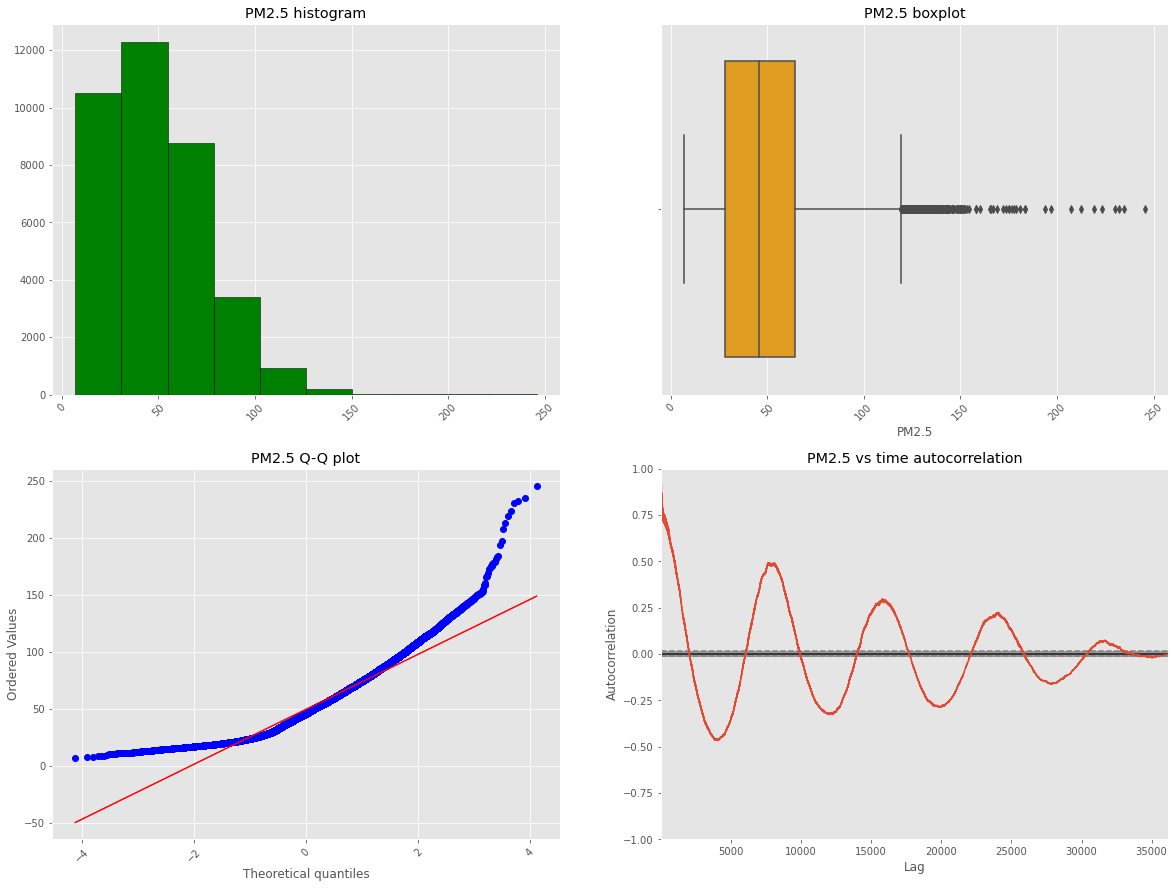

In [26]:
# Target variable visualization
plot_num(df1, var='PM2.5')

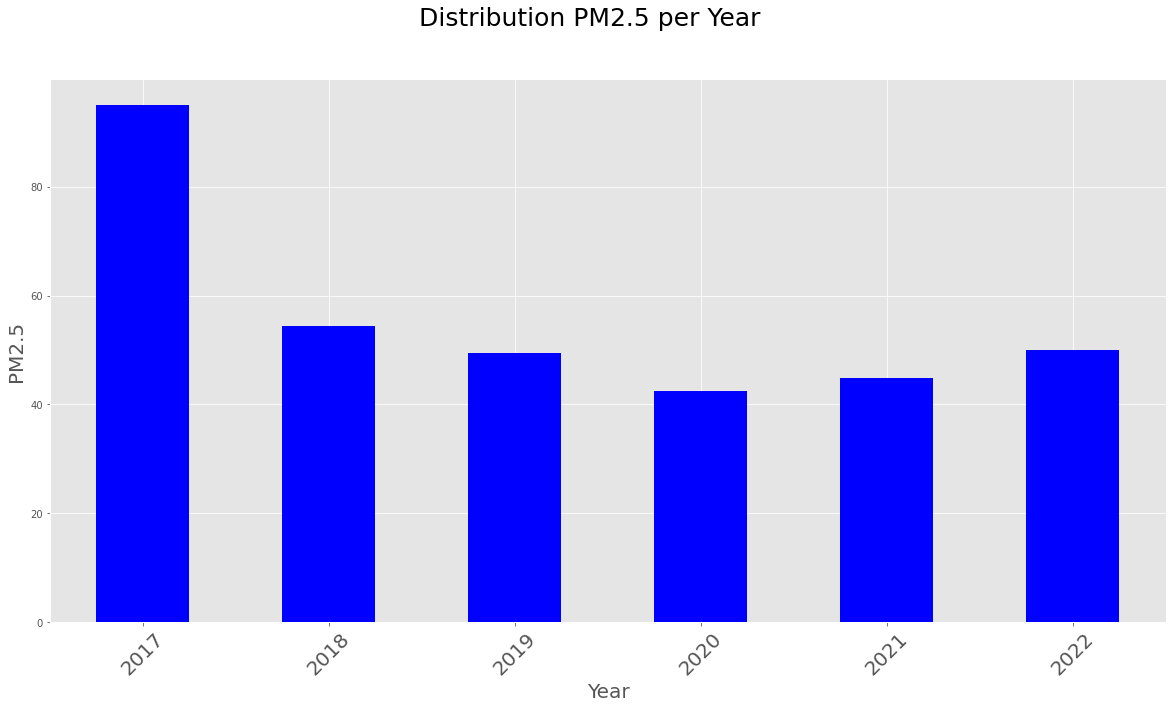

In [27]:
# Target variable distribution per year
barplot(df1, var='Year')

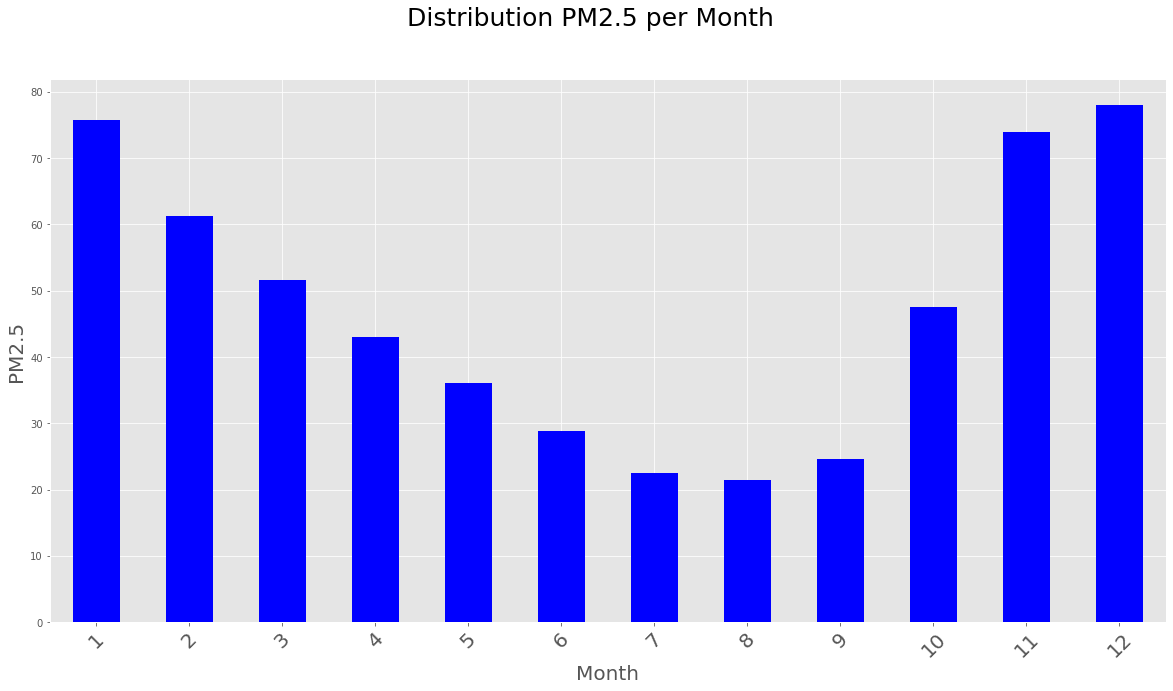

In [28]:
# Target variable distribution per month
barplot(df1, var='Month')

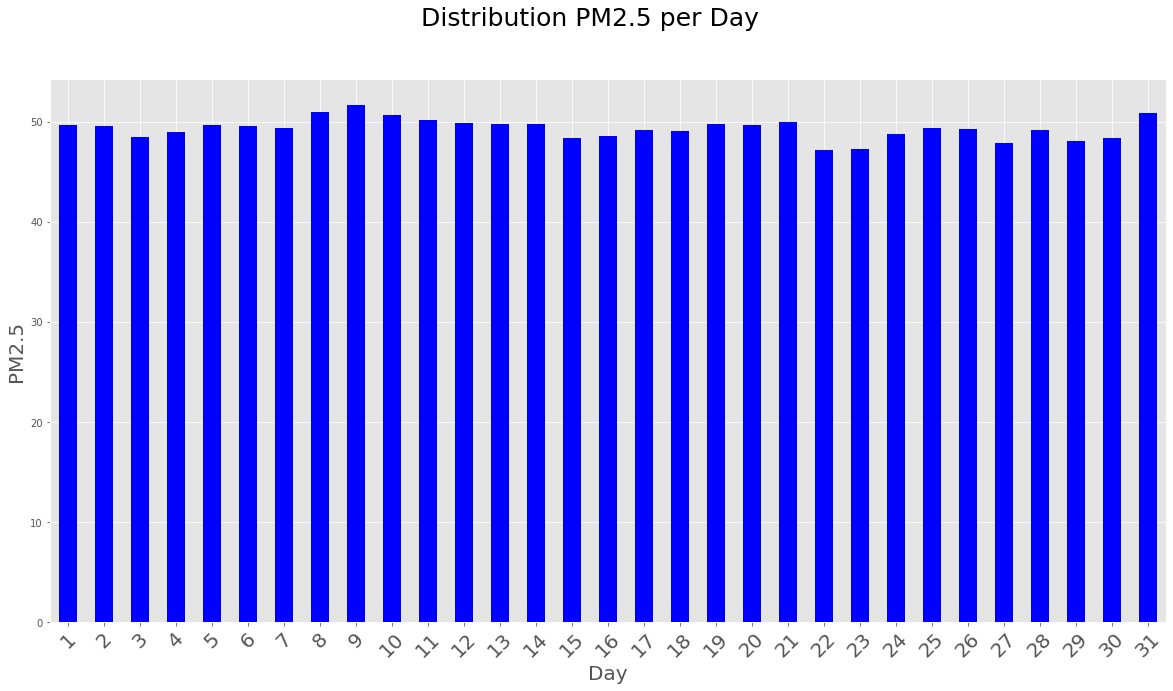

In [29]:
# Target variable distribution per day
barplot(df1, var='Day')

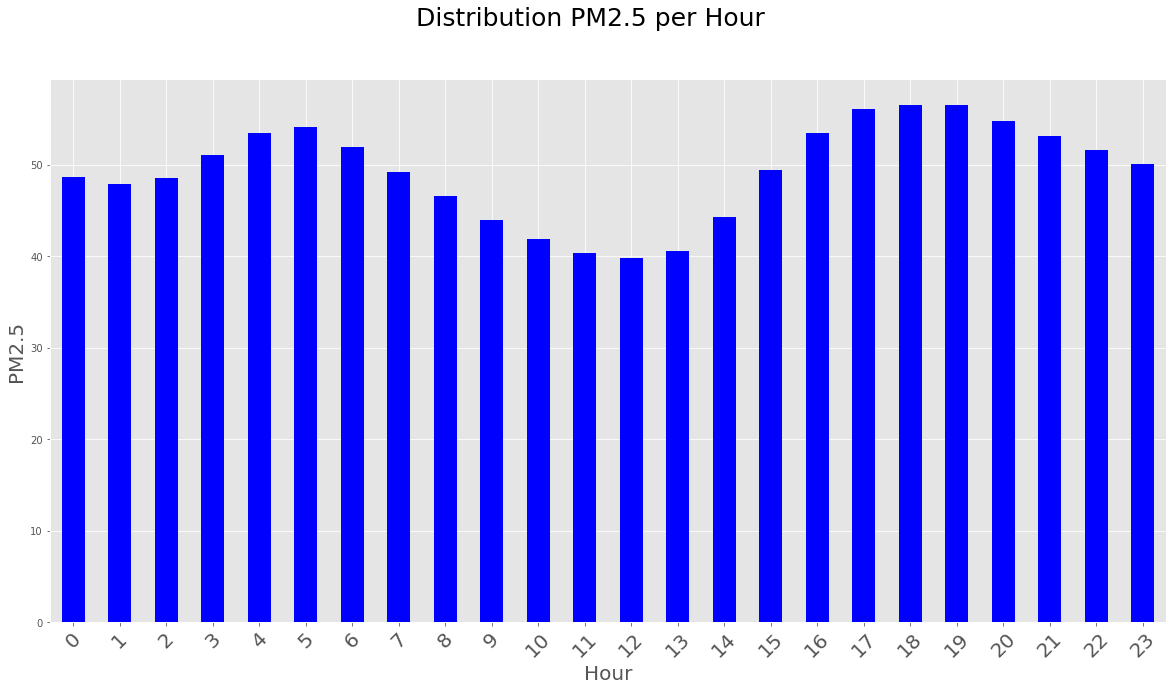

In [30]:
# Target variable distribution per hour
barplot(df1, var='Hour')

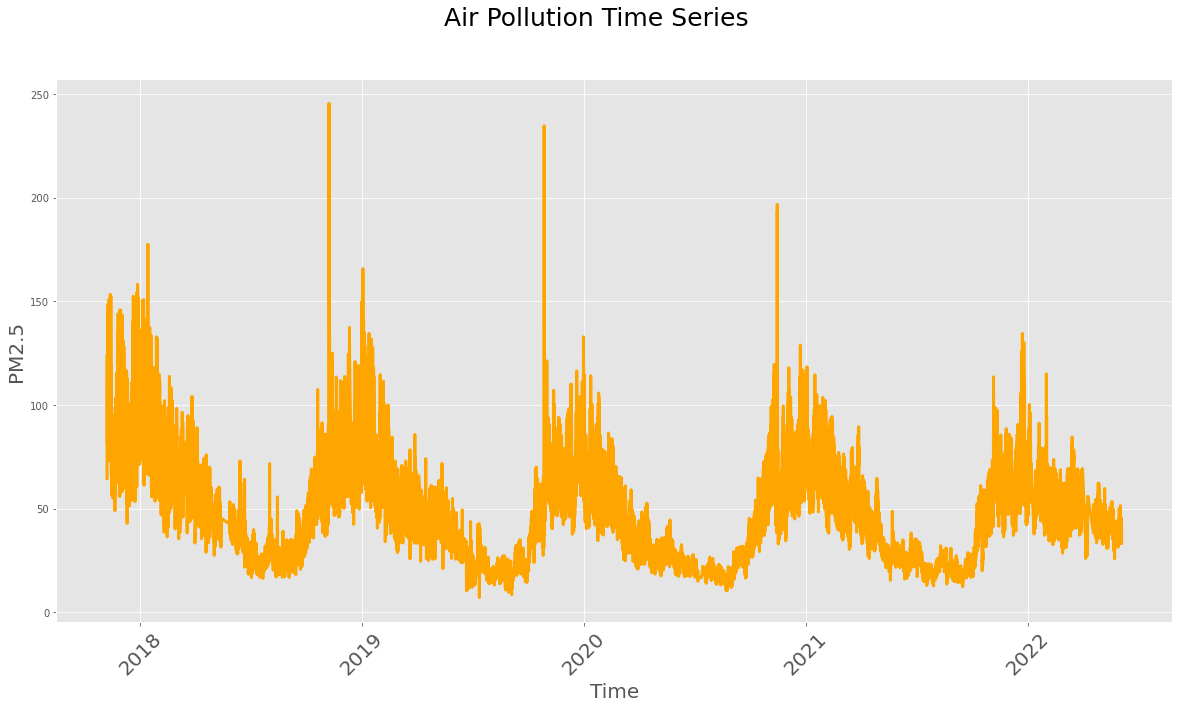

In [31]:
# Look at the whole Air Pollution time series
tsplot(df1, var='PM2.5', period='all')


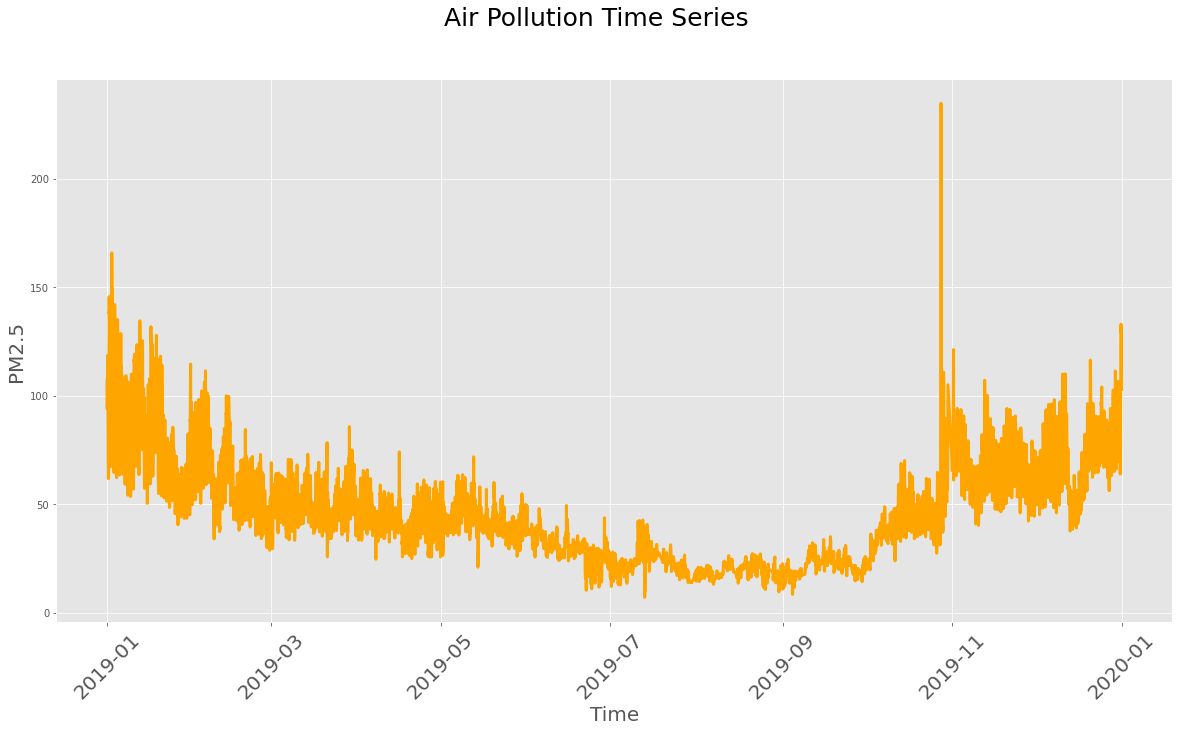

In [32]:
# Look at the single Air Pollution year
tsplot(df1,var='PM2.5', period='2019')


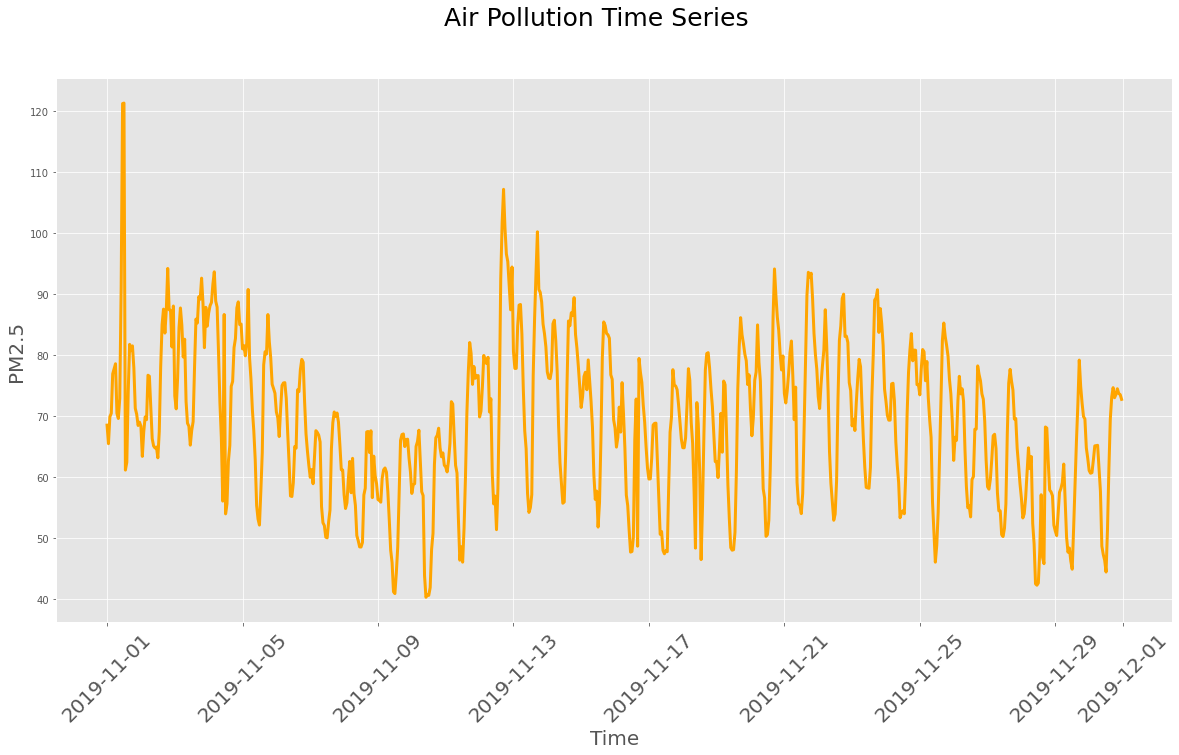

In [33]:
# Look at the single Air Pollution year-month
tsplot(df1,var='PM2.5', period='2019-11')


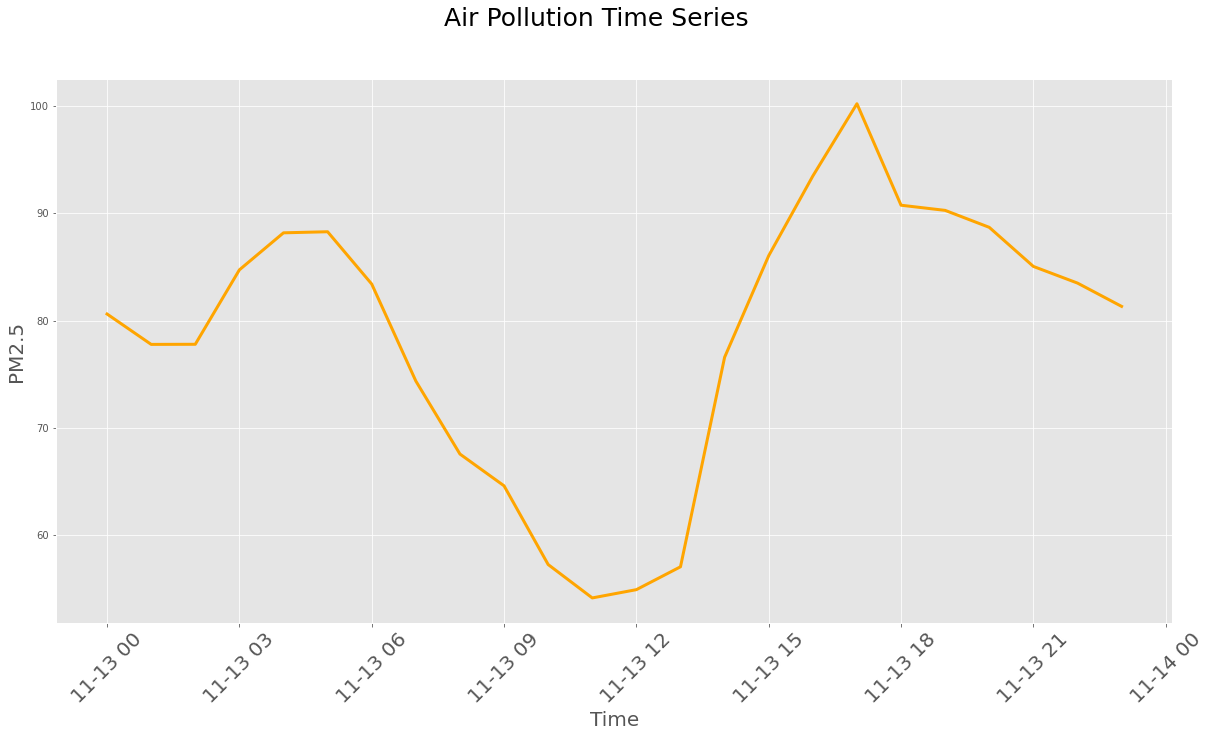

In [34]:
# Look at the single Air Pollution year-month-day
tsplot(df1,var='PM2.5', period='2019-11-13')


### Rolling window

In [35]:
# Create window features for rolling window
transformer = WindowFeatures(
    variables=["PM2.5"],
    functions=["mean", "std"],
    window=[24, 24 * 7, 24 * 365], # Day, week, year.
    freq="1H",
)

df2 = transformer.fit_transform(df1)
df2

,Year,Month,Day,Hour,PM2.5,PM2.5_window_24_mean,PM2.5_window_24_std,PM2.5_window_168_mean,PM2.5_window_168_std,PM2.5_window_8760_mean,PM2.5_window_8760_std
Timestamp,,,,,,,,,,,
2017-11-07 12:00:00,2017,11,7,12,64.51,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-07 13:00:00,2017,11,7,13,69.95,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-07 14:00:00,2017,11,7,14,92.79,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-07 15:00:00,2017,11,7,15,109.66,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-07 16:00:00,2017,11,7,16,116.50,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-04 11:00:00,2022,6,4,11,35.89,39.450000,3.943142,39.317500,4.344850,42.016067,19.113360
2022-06-04 12:00:00,2022,6,4,12,33.83,39.537500,3.833869,39.318333,4.344175,42.015701,19.113447
2022-06-04 13:00:00,2022,6,4,13,33.05,39.537083,3.834515,39.304226,4.358188,42.015573,19.113498


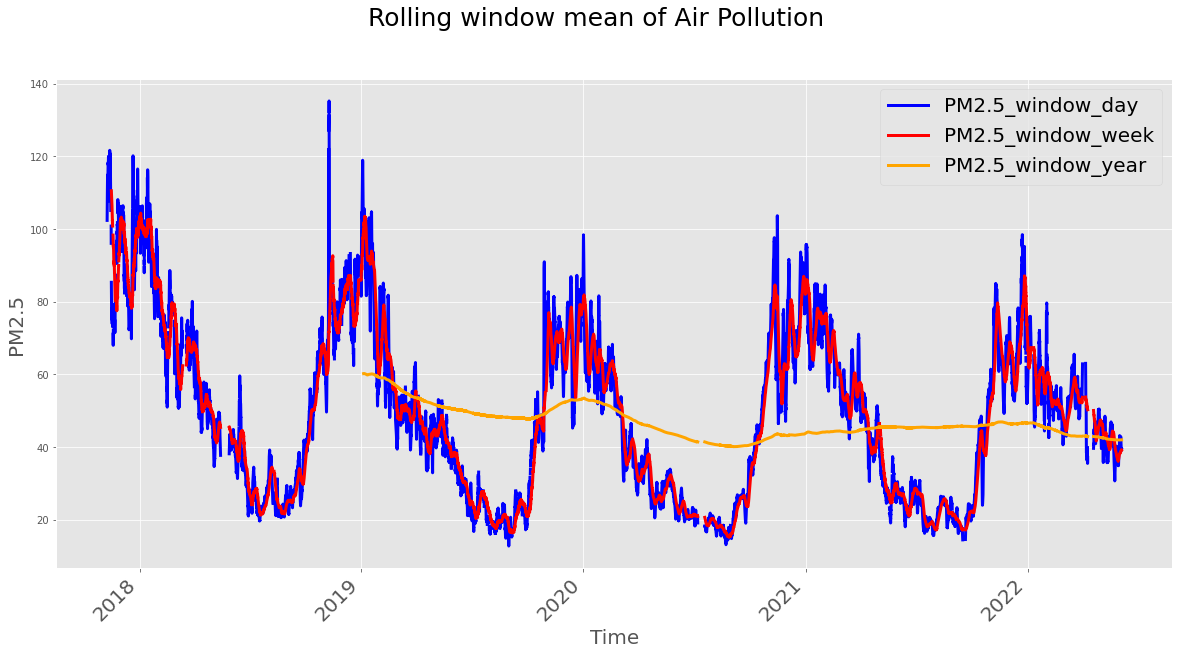

In [36]:
# Plot time series with mean rolling window for day, week and year 
colors = ['blue', 'red', 'orange']
df2.filter(
    regex="PM2.5_.*?_mean", # `.*?` means any number of any characters.
    axis=1  # Filter by column names.
).plot(color=colors, linewidth=3,figsize=(20,10))
my_labels=['PM2.5_window_day', 'PM2.5_window_week','PM2.5_window_year']
plt.suptitle("Rolling window mean of Air Pollution",fontsize=25)
plt.xlabel('Time', fontsize=20)
plt.ylabel('PM2.5', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.legend(my_labels,fontsize=20)
plt.show()

### Decomposition

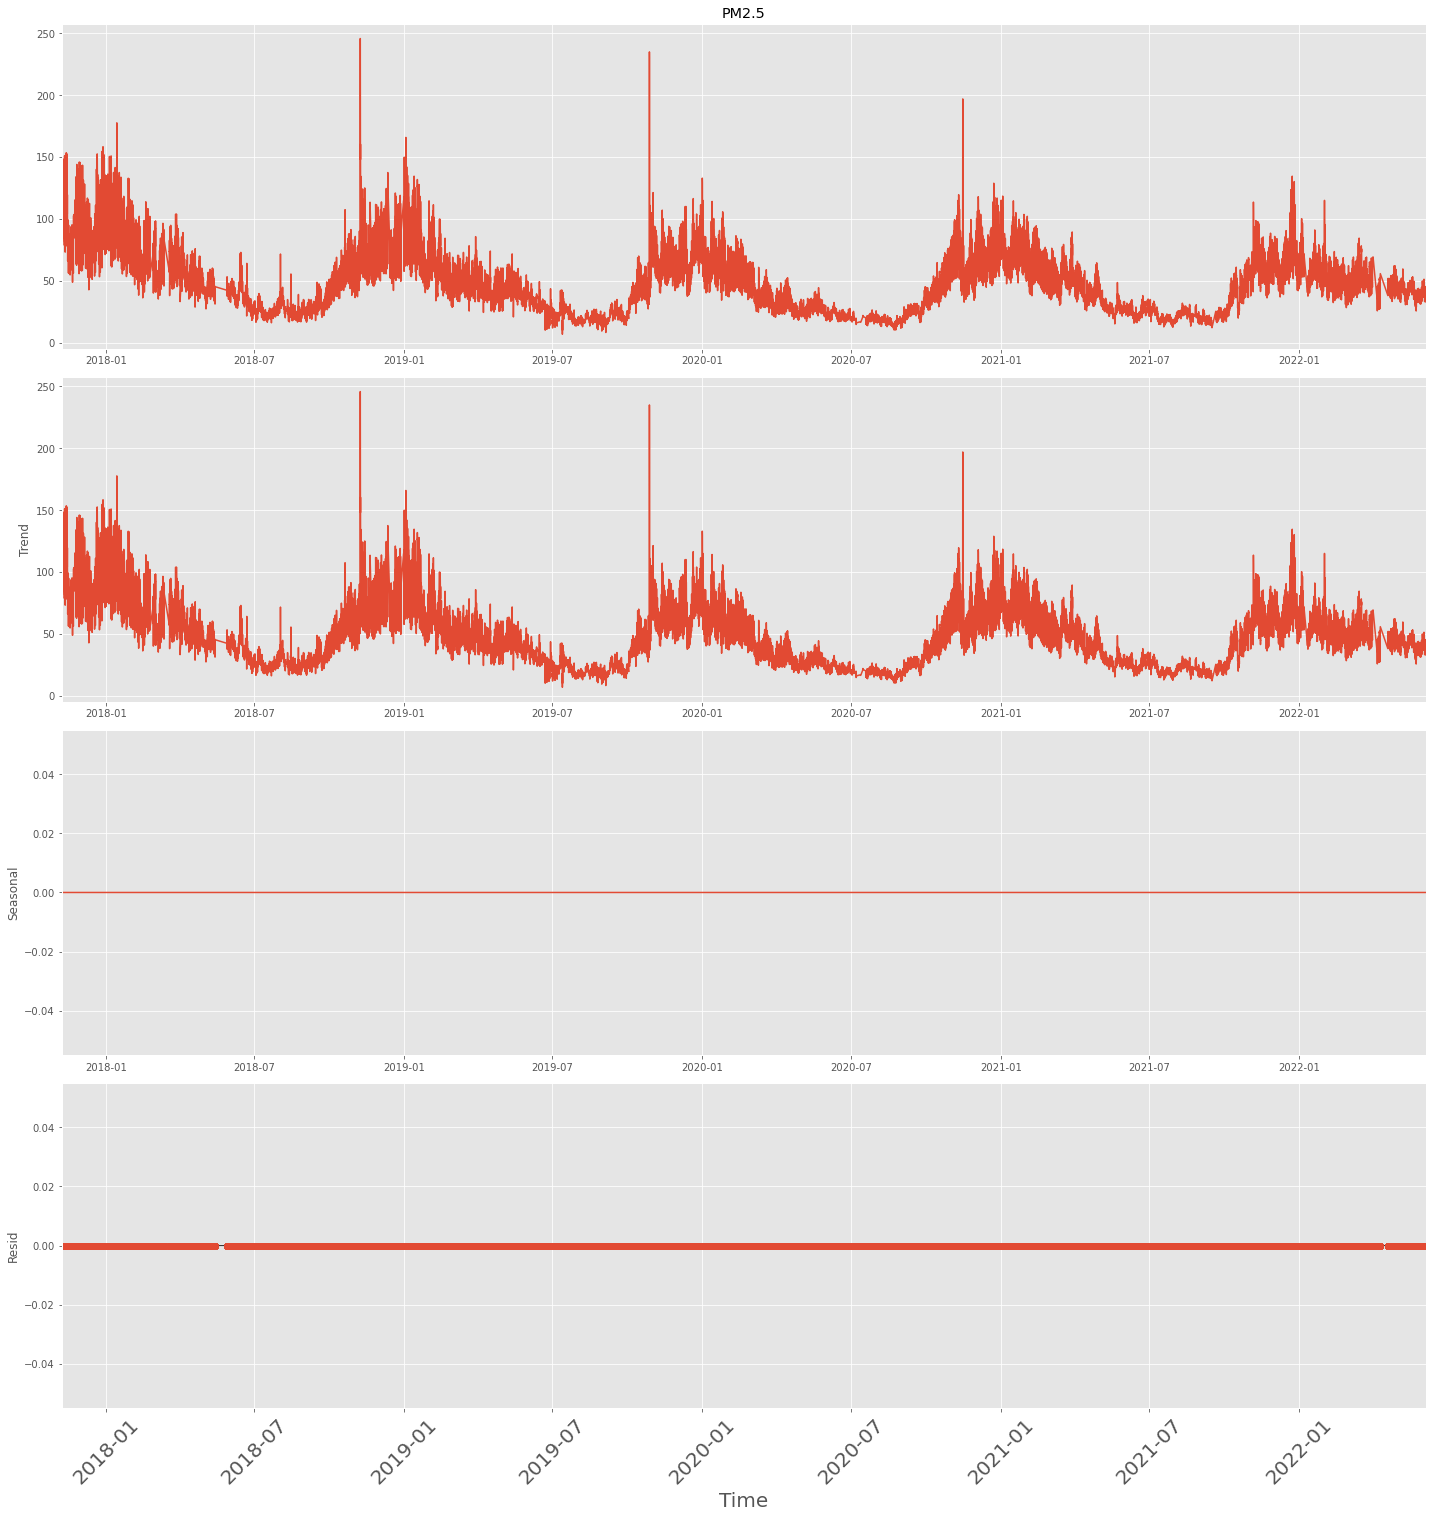

In [37]:
# Additive Decomposition
add_res = seasonal_decompose(x=df1['PM2.5'], model="additive", period=1)
plt.rcParams['figure.figsize']=(20,20)
add_res.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()

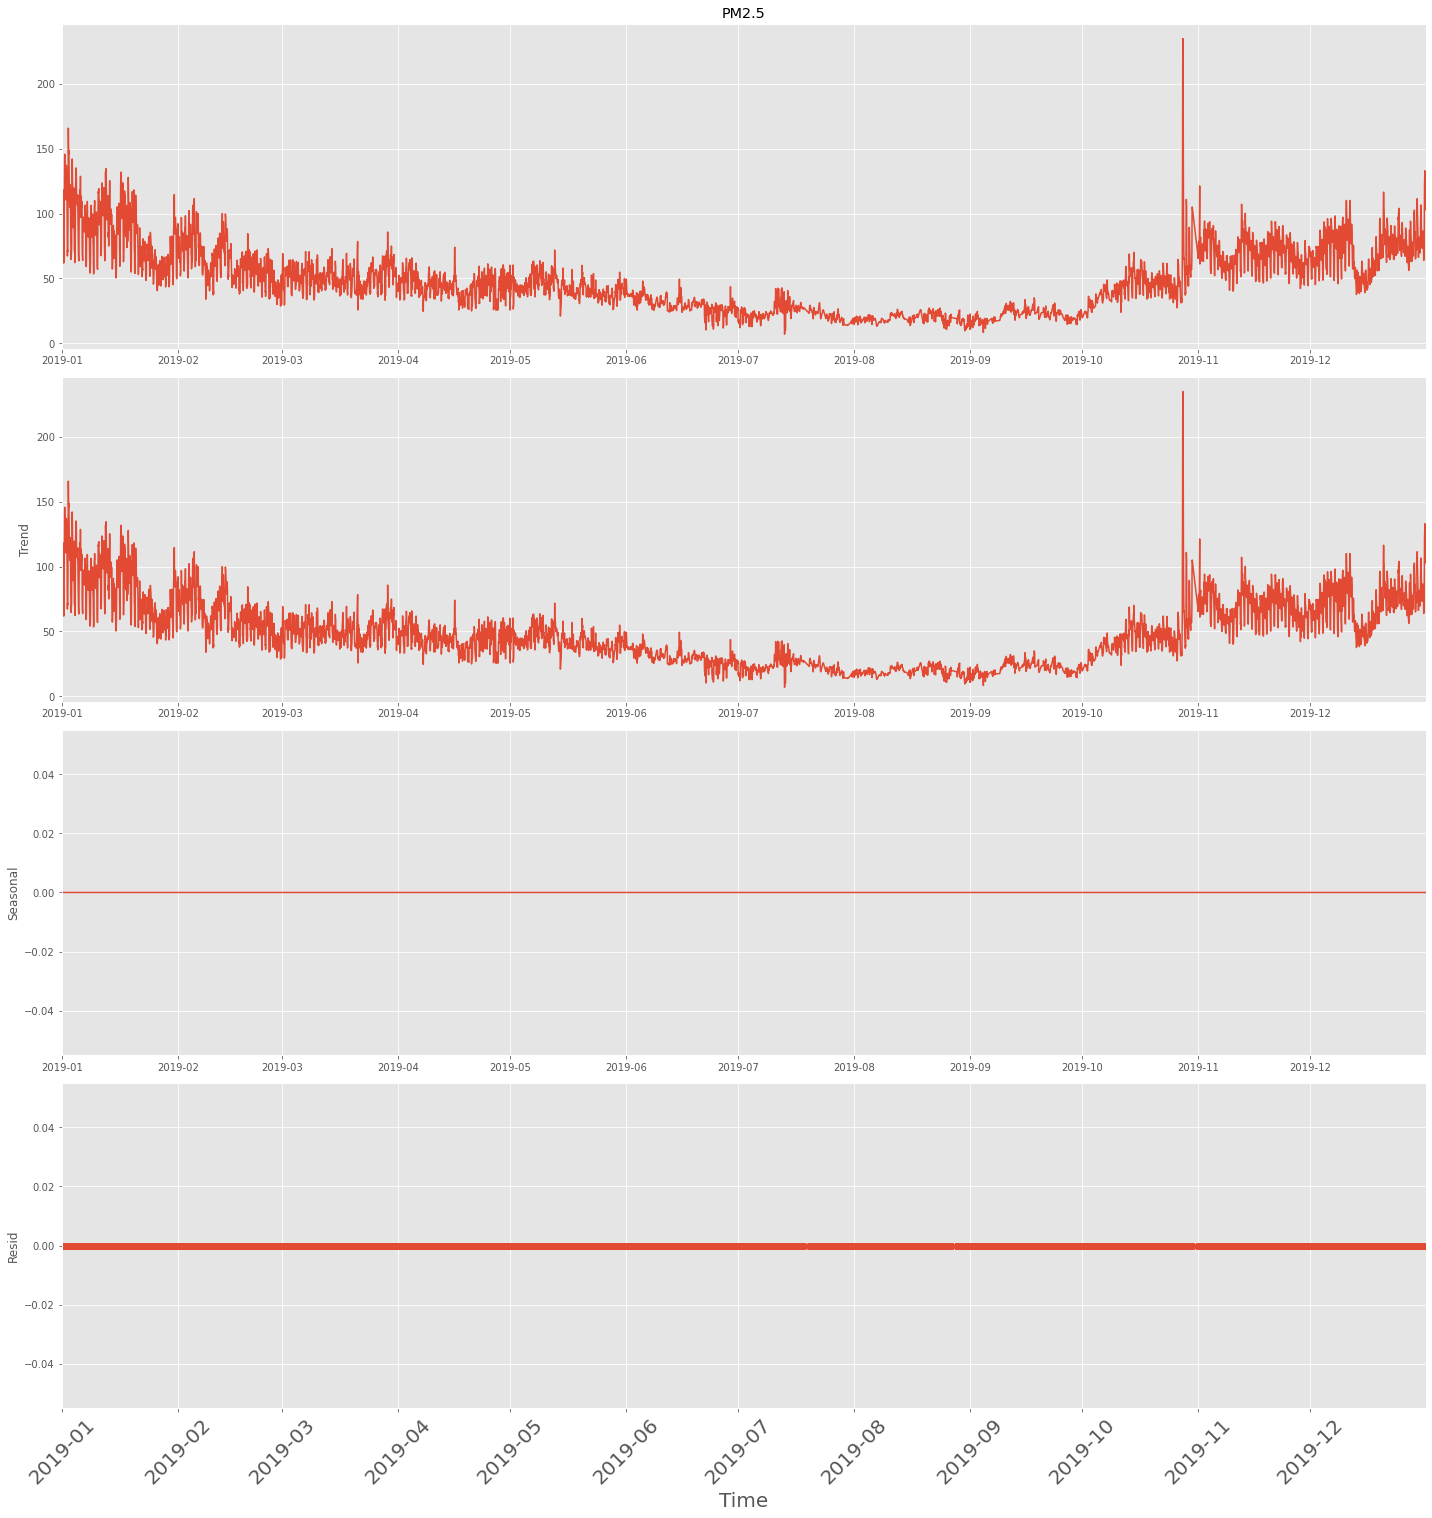

In [38]:
# Additive Decomposition year
add_res_2019 = seasonal_decompose(x=df1['PM2.5'].loc['2019'], model="additive", period=1)
plt.rcParams['figure.figsize']=(20,20)
add_res_2019.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()

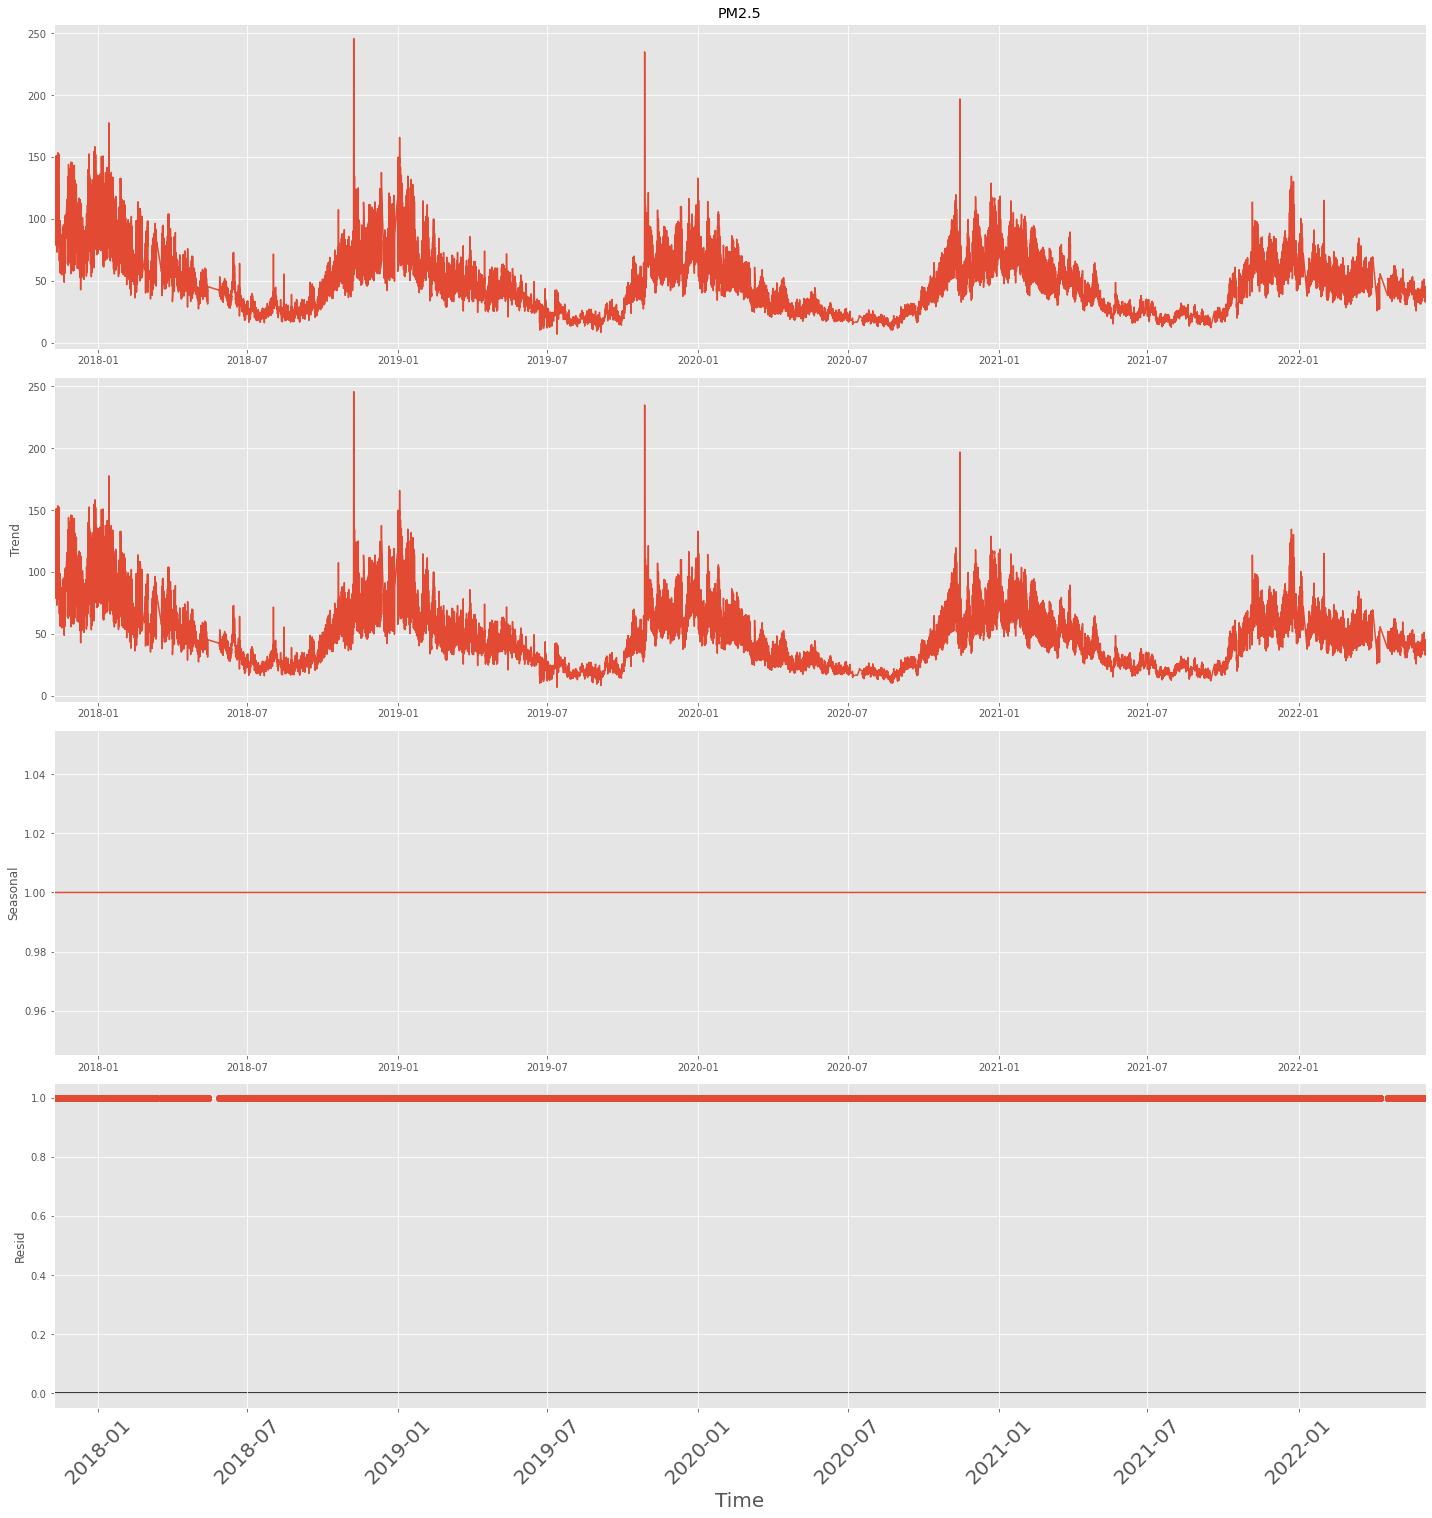

In [39]:
# Multiplicative Decomposition
mul_res = seasonal_decompose(x=df1['PM2.5'], model="multiplicative", period=1)
plt.rcParams['figure.figsize']=(20,20)
mul_res.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()



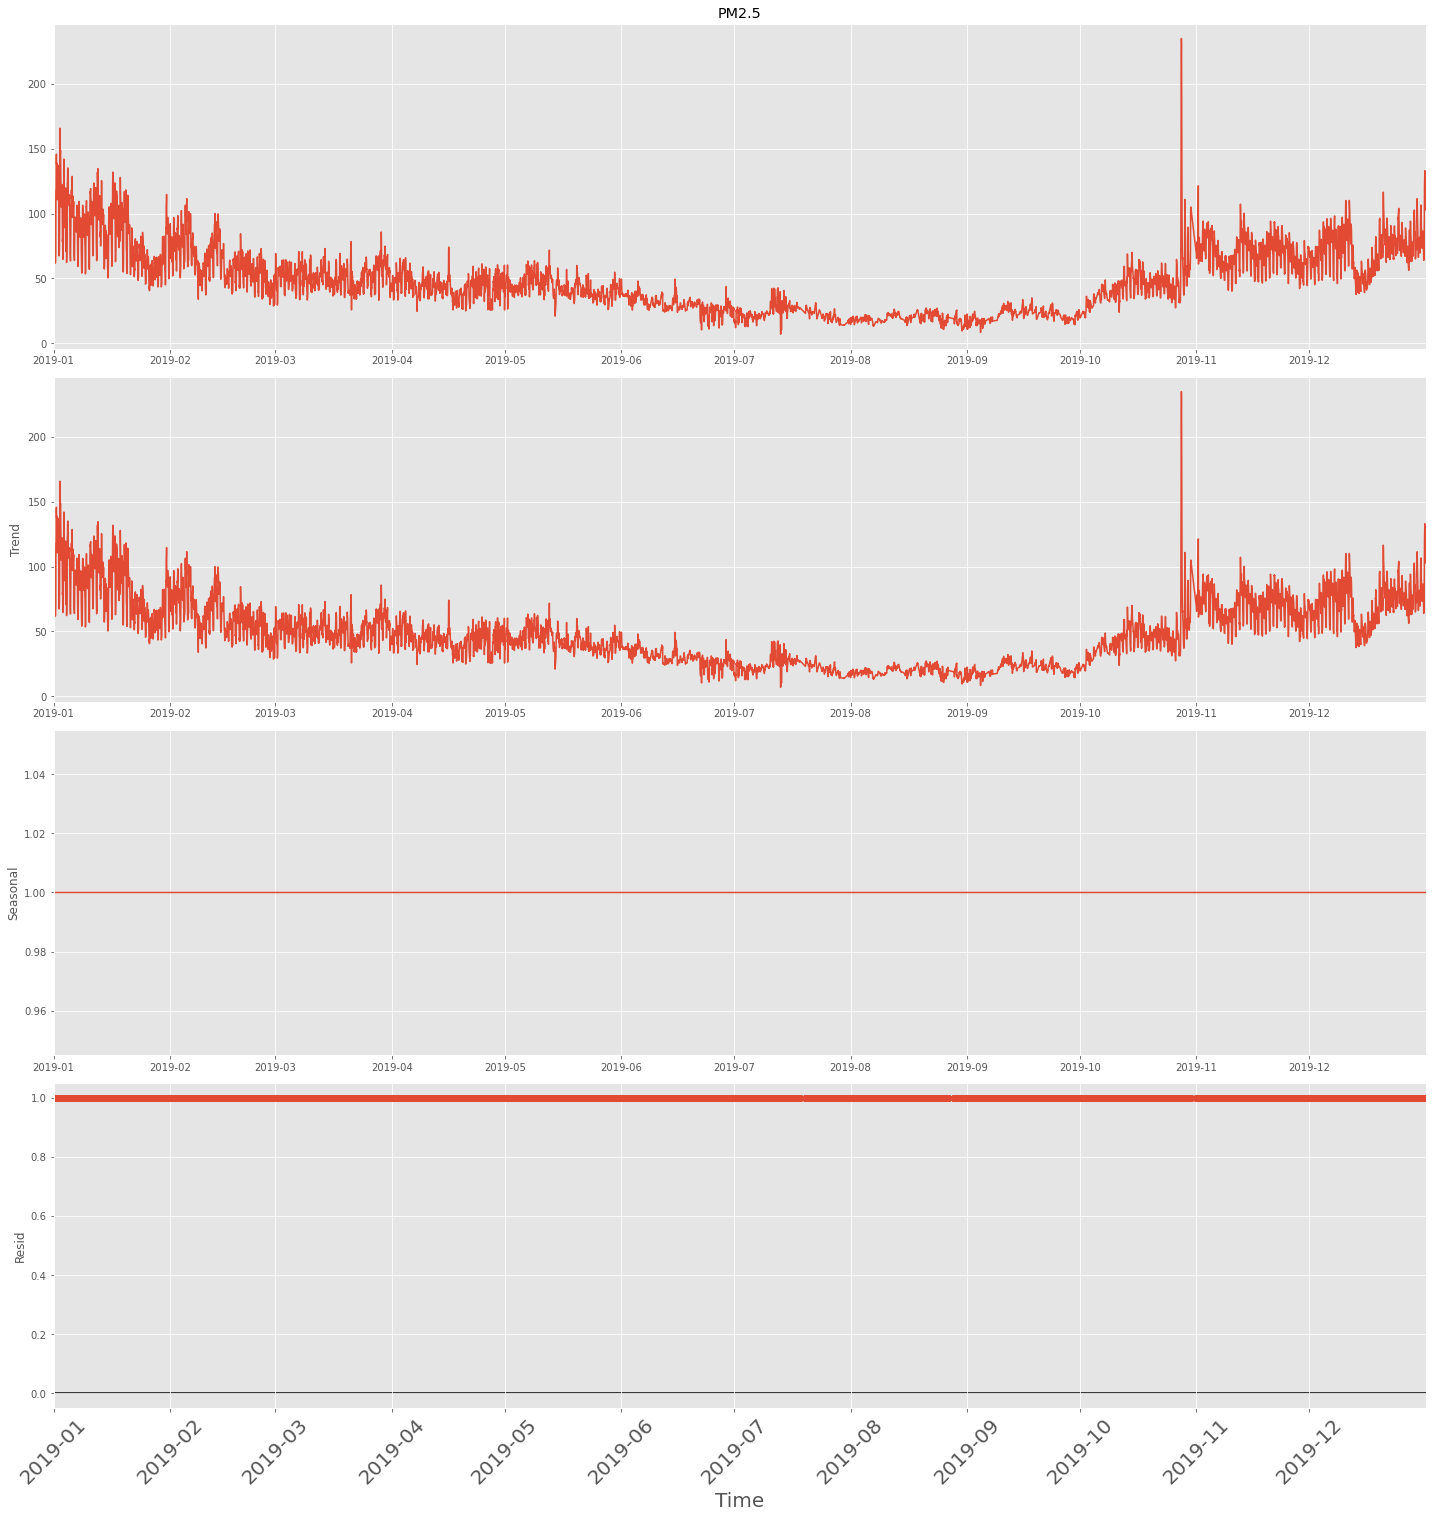

In [40]:
# Multiplicative Decomposition year
mul_res_2019 = seasonal_decompose(x=df1['PM2.5'].loc['2019'], model="multiplicative", period=1)
plt.rcParams['figure.figsize']=(20,20)
mul_res_2019.plot()
plt.xlabel('Time', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.show()

### Stationarity

In [41]:
# Augmented Dickey-Fuller test
X = df1['PM2.5'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -5.168240
p-value: 0.000010
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Remove outliers

In [42]:
ts = df1['PM2.5'].copy() 

In [43]:
# Outliers imputation with rolling median
ts_out = hampel(ts, window_size=24, imputation=True)


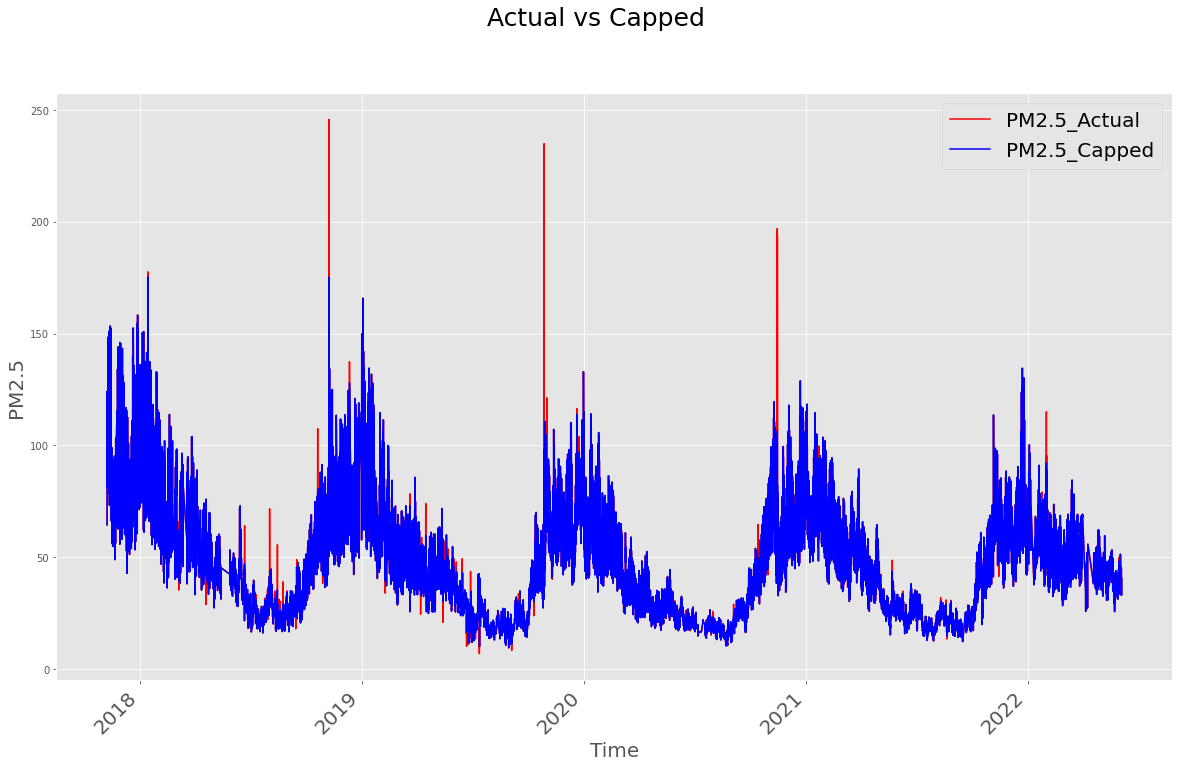

In [44]:
# Actual distribution vs Capped distribution plot
plt.rcParams['figure.figsize']=(20,12)
ts.plot(style="r-")
ts_out.plot(style="b-")
my_labels=['PM2.5_Actual', 'PM2.5_Capped']
plt.suptitle("Actual vs Capped",fontsize=25)
plt.xlabel('Time', fontsize=20)
plt.ylabel('PM2.5', fontsize=20)
plt.yticks(rotation=0)
plt.xticks(rotation=45, fontsize=20)
plt.legend(my_labels,fontsize=20)
plt.show()

### Feature Engineering with Lag features

In [45]:
# Lag features
df_lag = pd.concat(
    [
        ts_out,
        ts_out.shift(1).rename("lagged_1h"),
        ts_out.shift(2).rename("lagged_2h"),
        ts_out.shift(3).rename("lagged_3h"),
        ts_out.shift(24).rename("lagged_1d"),
        ts_out.shift(7 * 24).rename("lagged_7d"),
        ts_out.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        ts_out.shift(1).rolling(24).max().rename("lagged_max_24h"),
        ts_out.shift(1).rolling(24).min().rename("lagged_min_24h"),
        ts_out.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        ts_out.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        ts_out.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
)


In [46]:
df_lag.head()

,PM2.5,lagged_1h,lagged_2h,lagged_3h,lagged_1d,lagged_7d,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
Timestamp,,,,,,,,,,,,
2017-11-07 12:00:00,64.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-07 13:00:00,69.95,64.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-07 14:00:00,92.79,69.95,64.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-07 15:00:00,109.66,92.79,69.95,64.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-07 16:00:00,116.50,109.66,92.79,69.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df_lag.tail()

,PM2.5,lagged_1h,lagged_2h,lagged_3h,lagged_1d,lagged_7d,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
Timestamp,,,,,,,,,,,,
2022-06-04 11:00:00,35.89,34.71,35.84,36.63,33.79,35.75,39.450000,45.6,33.79,39.218958,51.41,31.41
2022-06-04 12:00:00,33.83,35.89,34.71,35.84,33.84,36.20,39.537500,45.6,33.84,39.219792,51.41,31.41
2022-06-04 13:00:00,33.05,33.83,35.89,34.71,34.29,35.98,39.537083,45.6,33.83,39.205685,51.41,31.41
2022-06-04 14:00:00,35.29,33.05,33.83,35.89,35.33,37.61,39.485417,45.6,33.05,39.188244,51.41,31.41
2022-06-04 15:00:00,40.67,35.29,33.05,33.83,38.85,41.22,39.483750,45.6,33.05,39.174435,51.41,31.41


In [48]:
# Remove nan values
df_lag = df_lag.dropna()

### Split dataset

In [49]:
y = df_lag['PM2.5']
X = df_lag.drop(['PM2.5'], axis=1)
# Test set on 1 month
split_point = len(df_lag) - 24*30
X_train, X_test = X[0:split_point], X[split_point:]
y_train, y_test = y[0:split_point], y[split_point:]

In [50]:
# Split for time series cross validation
ts_cv = TimeSeriesSplit(n_splits=3, test_size=24*30)
# splits
splits = list(ts_cv.split(X, y))

### Autoregressive model

In [51]:
# Features to introduce in the model
exog_train = X_train[['lagged_1d','lagged_7d','lagged_mean_24h','lagged_max_24h','lagged_min_24h','lagged_mean_7d','lagged_max_7d','lagged_min_7d']]
exog_test = X_test[['lagged_1d','lagged_7d','lagged_mean_24h','lagged_max_24h','lagged_min_24h','lagged_mean_7d','lagged_max_7d','lagged_min_7d']]


In [52]:
# train autoregression
AR = AutoReg(np.log1p(y_train), exog=exog_train, lags=3)
AR_model = AR.fit()
# make prediction
y_hat = AR_model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog_oos=exog_test)

In [53]:
# Evaluation
print('Test evaluation')
rmse = np.sqrt(mean_squared_error(np.log1p(y_test.values), y_hat.values))
#rmse = ((np.log1p(y_test.values) - y_hat.values) ** 2).mean() ** 0.5
print(f"root_mean_squared_error: {rmse:.3f} ± {rmse.std():.3f}")
mae = mean_absolute_error(np.log1p(y_test.values), y_hat.values)
#mae = (np.abs(np.log1p(y_test.values) - y_hat.values)).mean()
print(f"mean_absolute_error: {mae:.3f} ± {mae.std():.3f}")


Test evaluation
root_mean_squared_error: 0.112 ± 0.000
mean_absolute_error: 0.090 ± 0.000


In [54]:
# Build a dataframe with actual and predicted values
AR_test = np.expm1(y_hat)
AR_test_df = pd.DataFrame(AR_test, columns=['PM2.5_estimation'])
y_test_ = pd.DataFrame(y_test, columns=['PM2.5'])
df_AR_fin = pd.concat([y_test_['PM2.5'], AR_test_df.set_index(y_test_.index)], axis=1)

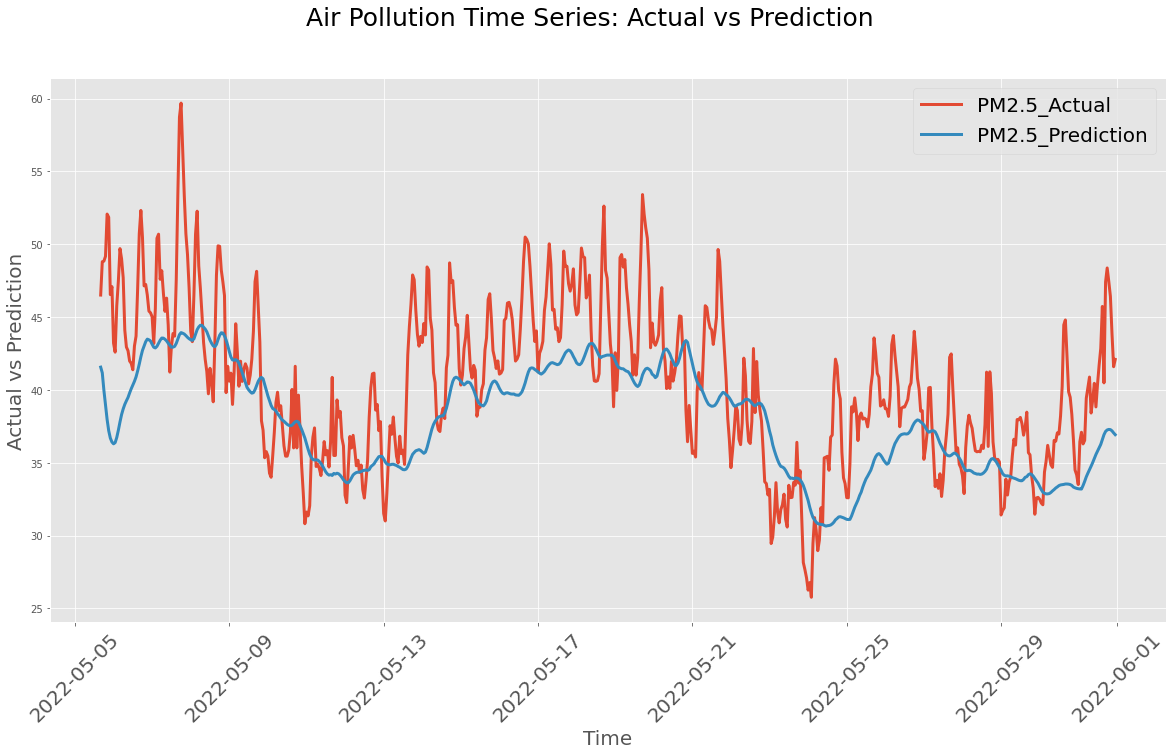

In [55]:
# Plot results on a time period
tsmultiplot(df_AR_fin,period='2022-05')
plt.show()

In [56]:
# Look at the model results
print(AR_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  PM2.5   No. Observations:                35304
Model:                   AutoReg-X(3)   Log Likelihood               36249.036
Method:               Conditional MLE   S.D. of innovations              0.087
Date:                Fri, 17 Feb 2023   AIC                         -72472.072
Time:                        01:52:25   BIC                         -72361.940
Sample:                             3   HQIC                        -72437.006
                                35304                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4885      0.008     61.677      0.000       0.473       0.504
PM2.5.L1            0.9911      0.005    184.168      0.000       0.981       1.002
PM2.5.L2            0.0141      

In [57]:
# Features Importance based on pvalues
print('AR Features Importance by pvalues')
AR_model.pvalues.sort_values()

AR Features Importance by pvalues


const               0.000000e+00
PM2.5.L1            0.000000e+00
PM2.5.L3           3.561163e-257
lagged_1d           2.097981e-36
lagged_mean_24h     4.224695e-24
lagged_7d           9.200168e-10
lagged_min_7d       2.060935e-08
lagged_min_24h      1.066390e-07
PM2.5.L2            6.094571e-02
lagged_max_24h      8.006166e-02
lagged_mean_7d      1.747504e-01
lagged_max_7d       6.219102e-01
dtype: float64

In [58]:
# Features Importance based on estimated coefficients
print('AR Features Importance by coefficients')
AR_model.params.sort_values(ascending=False)

AR Features Importance by coefficients


PM2.5.L1           0.991124
const              0.488543
PM2.5.L2           0.014067
lagged_mean_24h    0.002251
lagged_min_7d      0.000945
lagged_min_24h     0.000800
lagged_1d          0.000699
lagged_7d          0.000259
lagged_max_7d     -0.000033
lagged_max_24h    -0.000201
lagged_mean_7d    -0.000229
PM2.5.L3          -0.184246
dtype: float64

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
Partial regression plot of AIR Pollution on some features with AR model


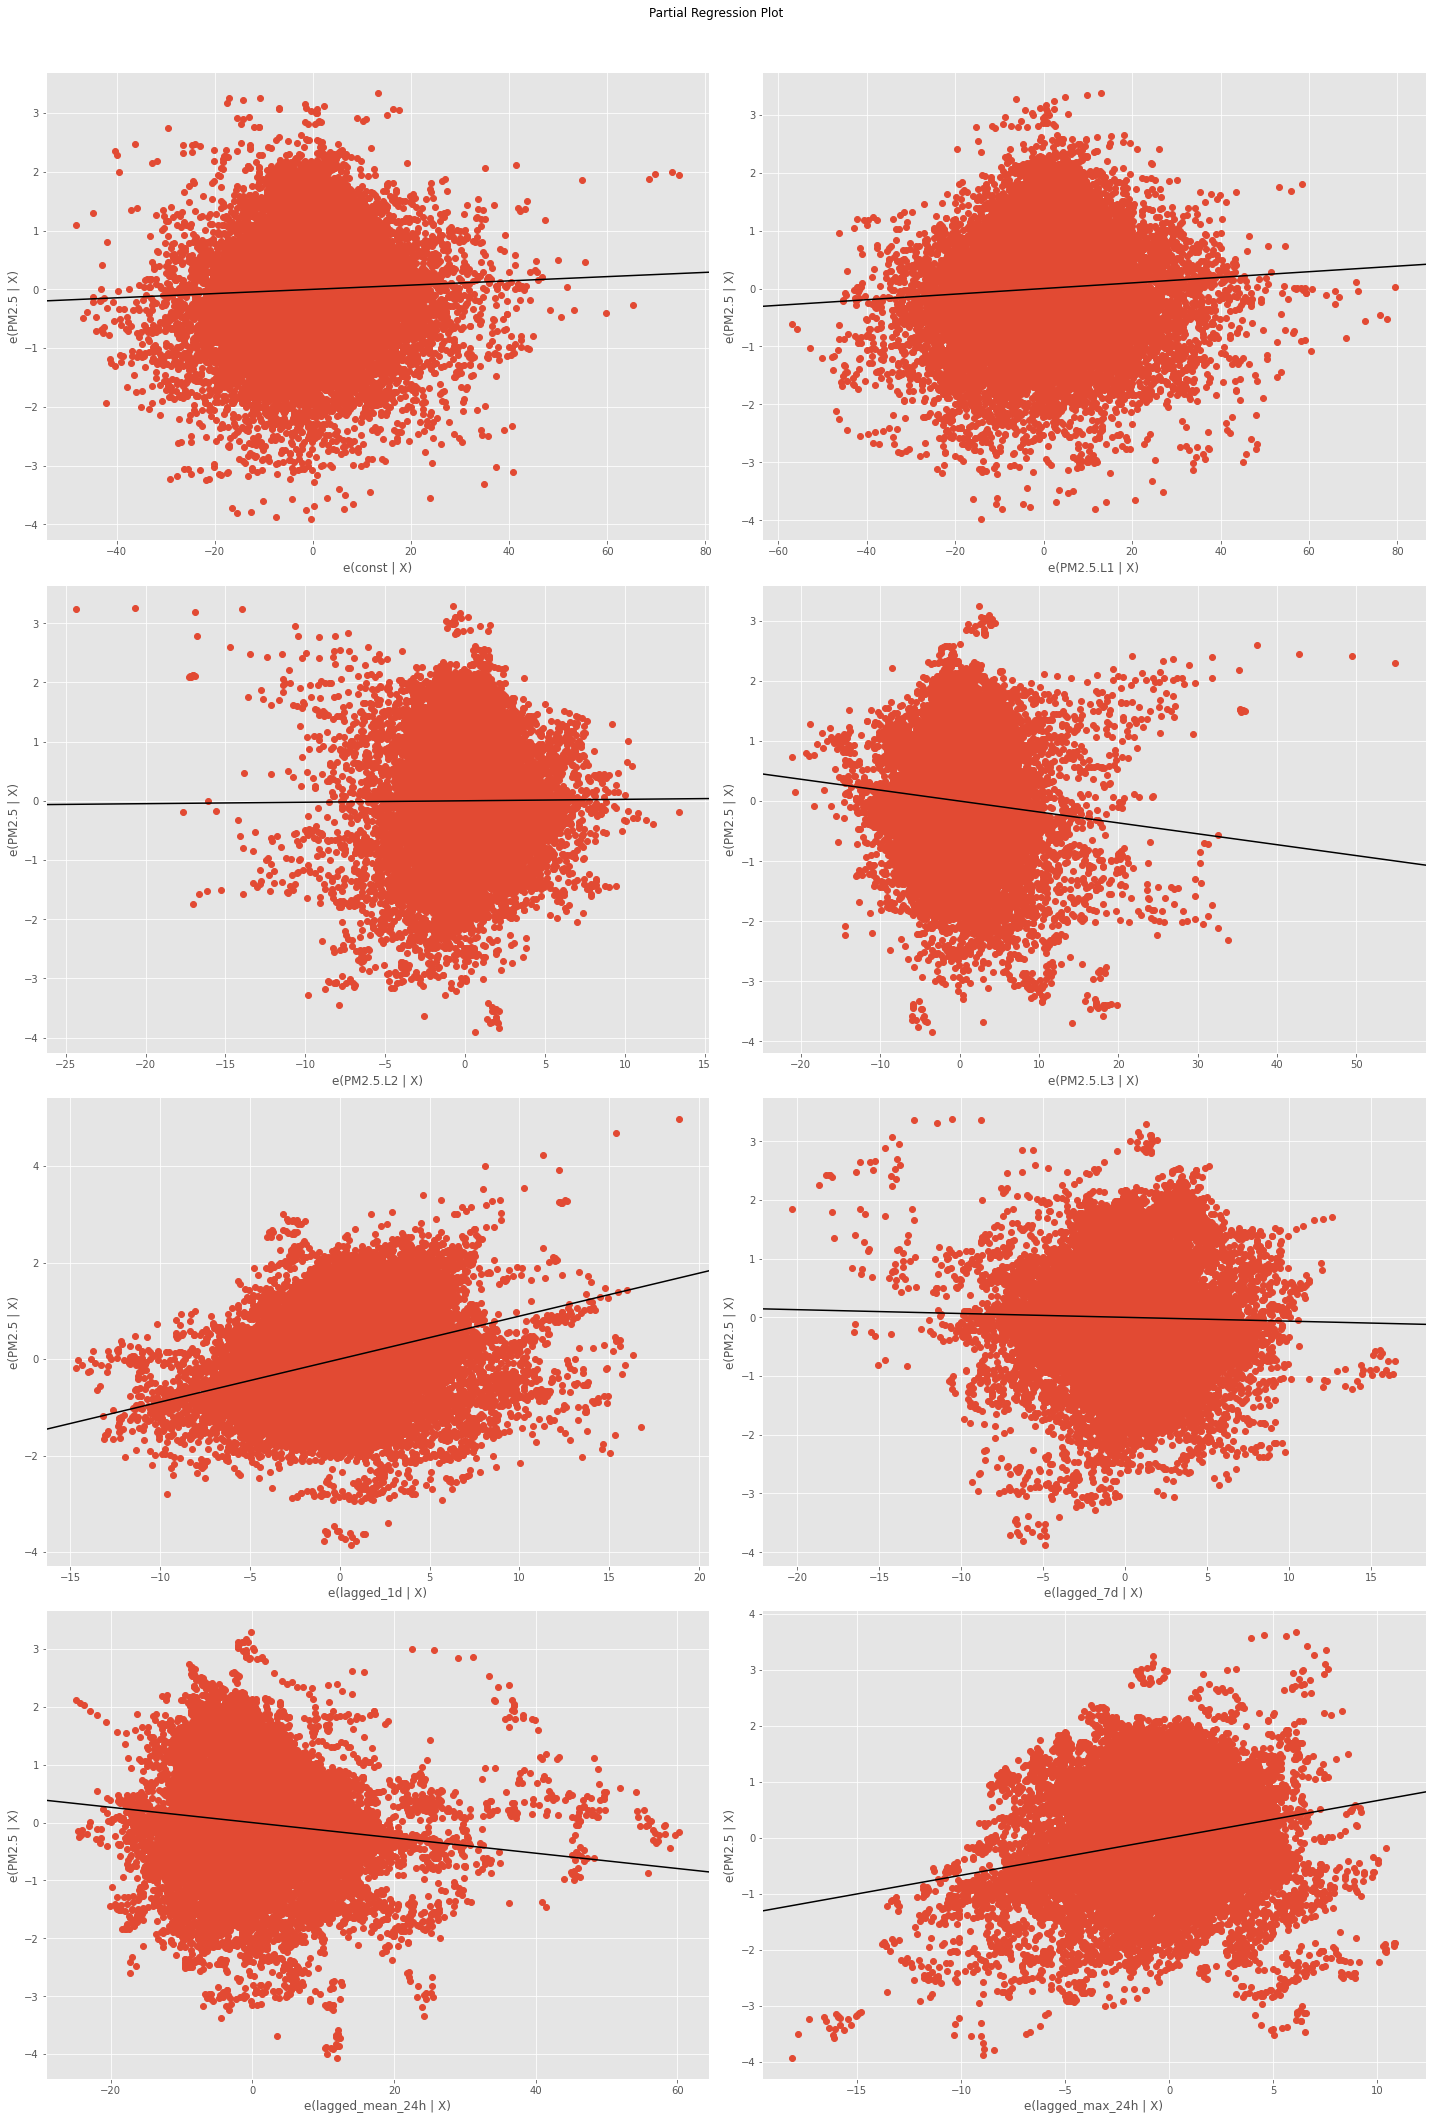

In [59]:

plt.rcParams['figure.figsize']=(20,30)
fig = sm.graphics.plot_partregress_grid(AR_model)
print("Partial regression plot of AIR Pollution on some features with AR model")
plt.show()

### Generalized Linear Models

In [60]:
# Evaluation
GLM = TweedieRegressor(power=1.5, link='log')
evaluate(GLM, X, np.log1p(y), cv=ts_cv)

Train evaluation
root_mean_squared_error: 0.169 ± 0.002
mean_absolute_error: 0.130 ± 0.002
Test evaluation
root_mean_squared_error: 0.126 ± 0.024
mean_absolute_error: 0.105 ± 0.021


In [61]:
# Prediction
GLM_model = GLM.fit(X_train, np.log1p(y_train))
GLM_train = np.expm1(GLM_model.predict(X_train))
GLM_train_df = pd.DataFrame(GLM_train, columns=['PM2.5_train'])
GLM_test = np.expm1(GLM_model.predict(X_test))
GLM_test_df = pd.DataFrame(GLM_test, columns=['PM2.5_test'])

In [62]:
# Build a dataframe with actual and predicted values
df1 = GLM_train_df.transpose().reset_index(drop=True).transpose()
df2 = GLM_test_df.transpose().reset_index(drop=True).transpose()
dfs = [df1,df2]
df_ = pd.concat(dfs,axis=0,ignore_index=True)
dfs_= df_.rename(columns= {0:'PM2.5_estimation'})
df_GLM_fin = pd.concat([df_lag['PM2.5'], dfs_.set_index(df_lag.index)], axis=1)

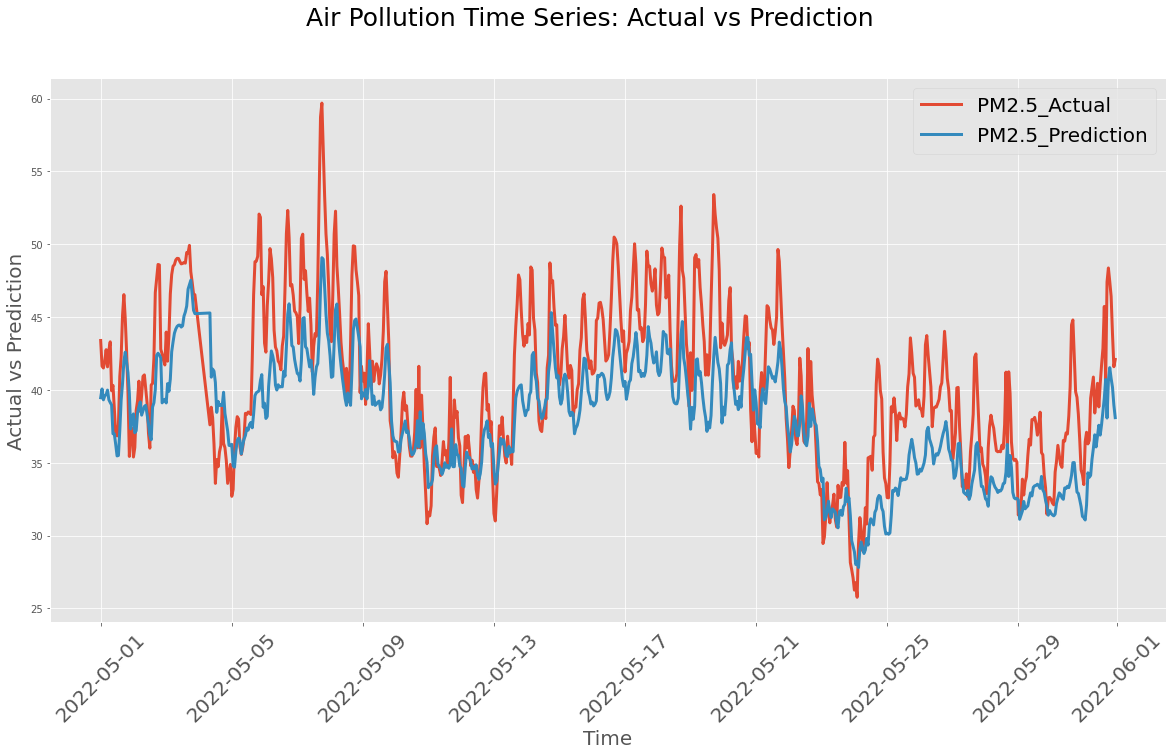

In [63]:
# Plot results on a time period
tsmultiplot(df_GLM_fin,period='2022-05')
plt.show()

In [64]:
# Features Importance
print('GLM Features Permutation Importance')
#GLM_model = GLM.fit(X_train, np.log1p(y_train))
GLM_perm = PermutationImportance(GLM_model, random_state=0).fit(X_test, np.log1p(y_test))
eli5.show_weights(GLM_perm, feature_names = X_test.columns.tolist())


GLM Features Permutation Importance


Weight,Feature
0.6173 ± 0.0695,lagged_1h
0.4461 ± 0.0475,lagged_mean_24h
0.2067 ± 0.0195,lagged_mean_7d
0.1572 ± 0.0245,lagged_min_7d
0.1022 ± 0.0133,lagged_max_24h
0.0251 ± 0.0079,lagged_max_7d
0.0249 ± 0.0077,lagged_1d
0.0066 ± 0.0013,lagged_2h
0.0022 ± 0.0012,lagged_7d
-0.0007 ± 0.0013,lagged_min_24h


Partial dependence of AIR Pollution on some features with GLM model


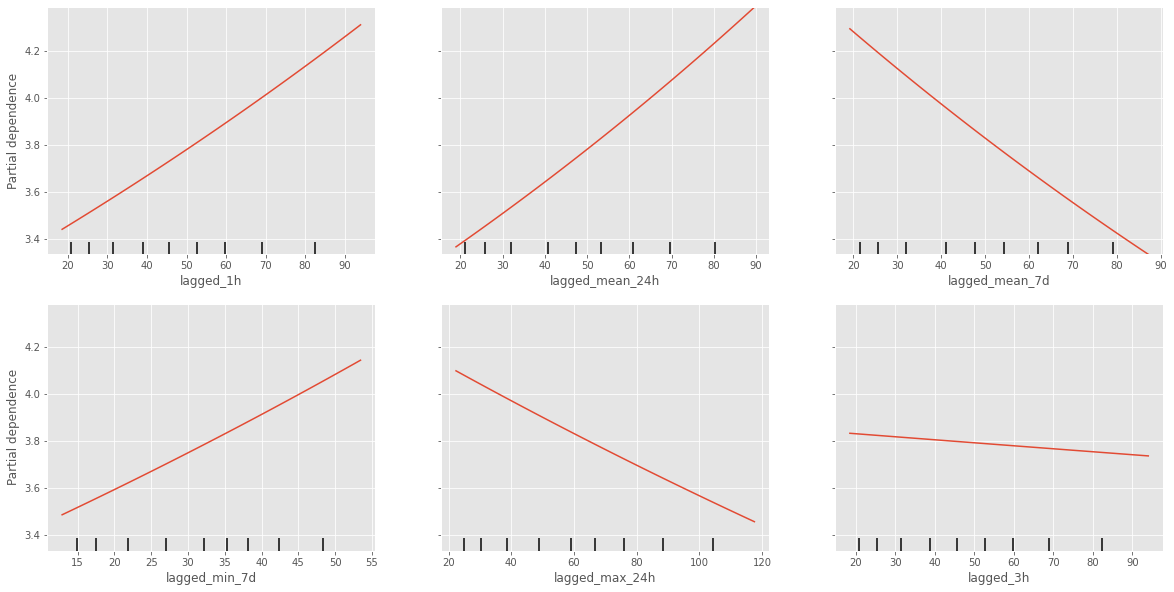

In [65]:
plt.rcParams['figure.figsize']=(20,10)
PartialDependenceDisplay.from_estimator(GLM_model,X,
['lagged_1h', 'lagged_mean_24h','lagged_mean_7d',
 'lagged_min_7d','lagged_max_24h','lagged_3h'], 
                                        kind='average', random_state=0)
print("Partial dependence of AIR Pollution on some features with GLM model")
plt.show()

### Explainable Boosting Machine

In [66]:
# Evaluation
EBM = ExplainableBoostingRegressor(random_state=0)
evaluate(EBM, X, np.log1p(y), cv=ts_cv)

Train evaluation
root_mean_squared_error: 0.084 ± 0.000
mean_absolute_error: 0.060 ± 0.000
Test evaluation
root_mean_squared_error: 0.065 ± 0.011
mean_absolute_error: 0.049 ± 0.006


In [67]:
# Prediction
EBM_model = EBM.fit(X_train, np.log1p(y_train))
ebm_train = np.expm1(EBM_model.predict(X_train))
ebm_train_df = pd.DataFrame(ebm_train, columns=['PM2.5_train'])
ebm_test = np.expm1(EBM_model.predict(X_test))
ebm_test_df = pd.DataFrame(ebm_test, columns=['PM2.5_test'])

In [68]:
# Build a dataframe with actual and predicted values
df1 = ebm_train_df.transpose().reset_index(drop=True).transpose()
df2 = ebm_test_df.transpose().reset_index(drop=True).transpose()
dfs = [df1,df2]
df_ = pd.concat(dfs,axis=0,ignore_index=True)
dfs_= df_.rename(columns= {0:'PM2.5_estimation'})
df_EBM_fin = pd.concat([df_lag['PM2.5'], dfs_.set_index(df_lag.index)], axis=1)

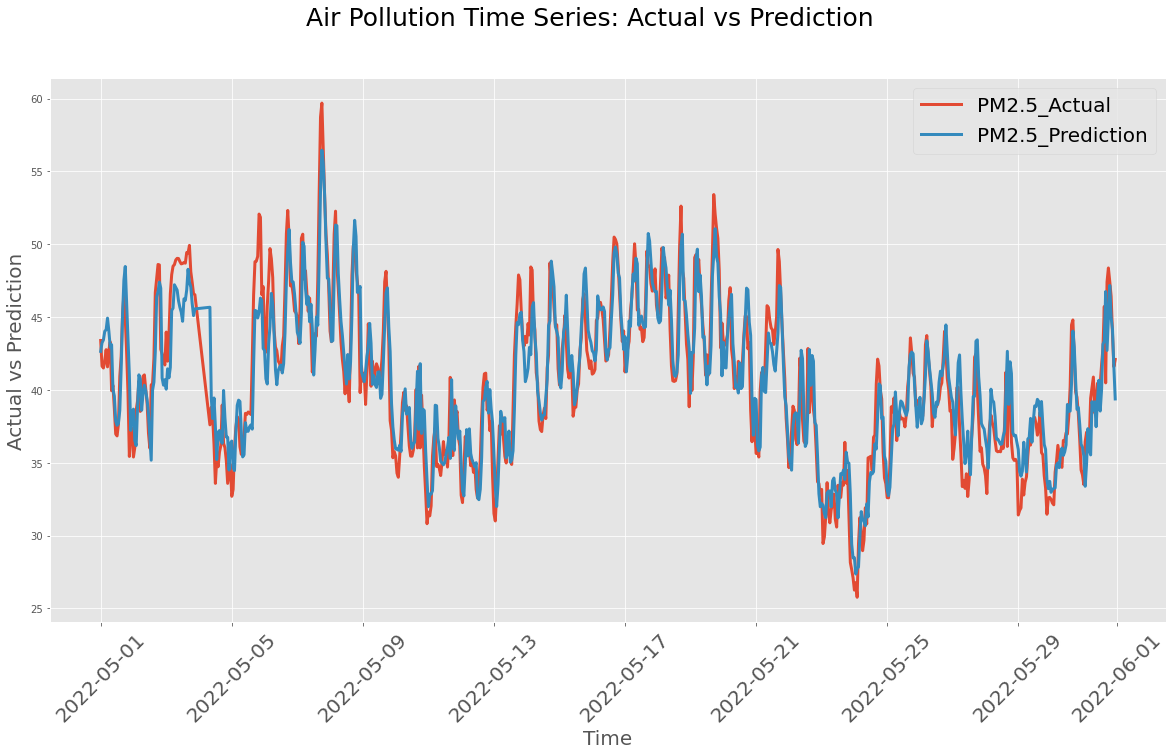

In [69]:
# Plot results on a time period
tsmultiplot(df_EBM_fin,period='2022-05')
plt.show()

In [70]:
# Features Importance
print('EBM Features Permutation Importance')
#EBM_model = EBM.fit(X_train, np.log1p(y_train))
EBM_perm = PermutationImportance(EBM_model, random_state=0).fit(X_test, np.log1p(y_test))
eli5.show_weights(EBM_perm, feature_names = X_test.columns.tolist())


EBM Features Permutation Importance


Weight,Feature
0.9320 ± 0.0837,lagged_1h
0.0562 ± 0.0066,lagged_1d
0.0401 ± 0.0040,lagged_2h
0.0121 ± 0.0034,lagged_3h
0.0113 ± 0.0027,lagged_max_24h
0.0073 ± 0.0031,lagged_mean_24h
0.0033 ± 0.0023,lagged_7d
0.0031 ± 0.0027,lagged_mean_7d
0.0024 ± 0.0021,lagged_min_24h
-0.0016 ± 0.0034,lagged_min_7d


Partial dependence of AIR Pollution on some features with EBM model


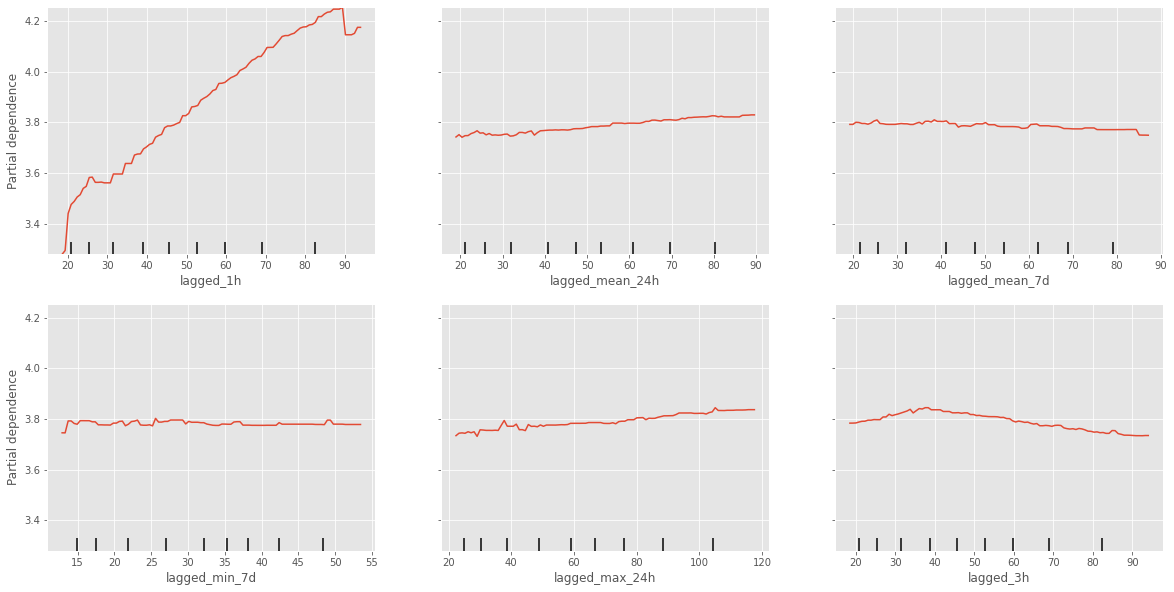

In [71]:
plt.rcParams['figure.figsize']=(20,10)
PartialDependenceDisplay.from_estimator(EBM_model,X,
['lagged_1h', 'lagged_mean_24h','lagged_mean_7d',
 'lagged_min_7d','lagged_max_24h','lagged_3h'], 
                                        kind='average', random_state=0)
print("Partial dependence of AIR Pollution on some features with EBM model")
plt.show()

### Random Forest

In [72]:
# evaluation
RF = RandomForestRegressor(random_state=0)
evaluate(RF, X, np.log1p(y), cv=ts_cv)

Train evaluation
root_mean_squared_error: 0.031 ± 0.000
mean_absolute_error: 0.021 ± 0.000
Test evaluation
root_mean_squared_error: 0.058 ± 0.009
mean_absolute_error: 0.042 ± 0.004


In [73]:
# Prediction
RF_model = RF.fit(X_train, np.log1p(y_train))
rf_train = np.expm1(RF_model.predict(X_train))
rf_train_df = pd.DataFrame(rf_train, columns=['PM2.5_train'])
rf_test = np.expm1(RF_model.predict(X_test))
rf_test_df = pd.DataFrame(rf_test, columns=['PM2.5_test'])

In [74]:
# Build a dataframe with actual and predicted values
df1 = rf_train_df.transpose().reset_index(drop=True).transpose()
df2 = rf_test_df.transpose().reset_index(drop=True).transpose()
dfs = [df1,df2]
df_ = pd.concat(dfs,axis=0,ignore_index=True)
dfs_= df_.rename(columns= {0:'PM2.5_estimation'})
df_RF_fin = pd.concat([df_lag['PM2.5'], dfs_.set_index(df_lag.index)], axis=1)

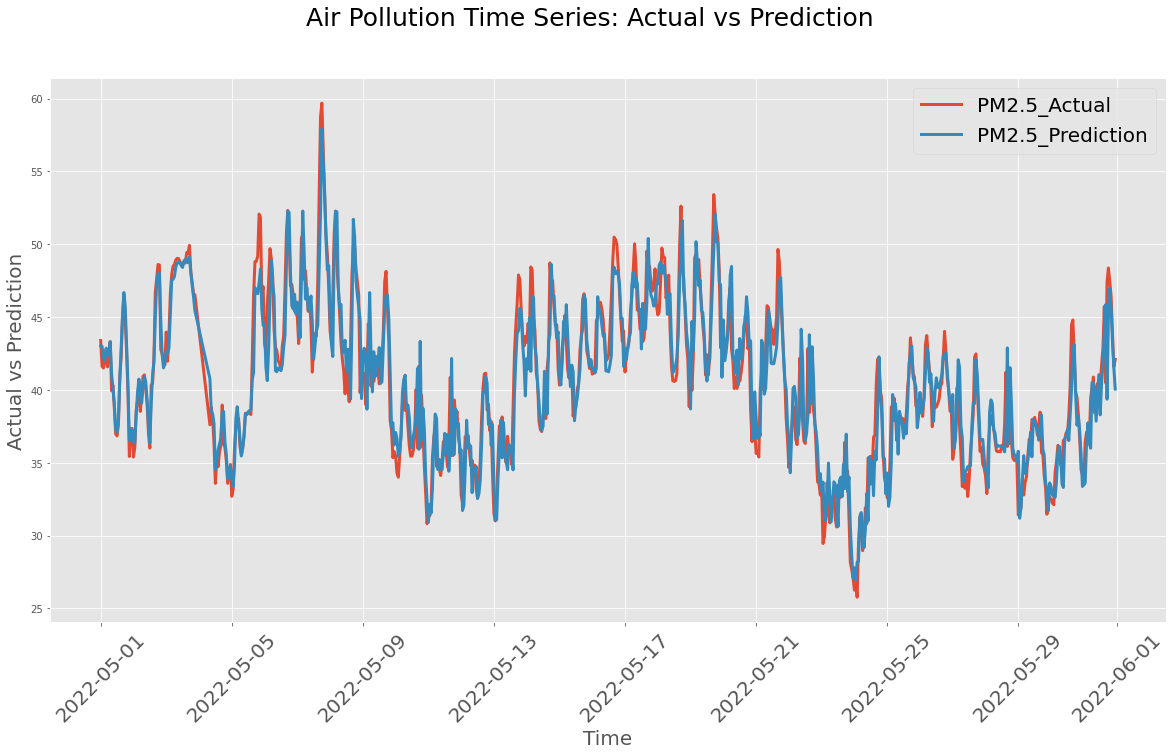

In [75]:
# Plot results on a period year
tsmultiplot(df_RF_fin,period='2022-05')
plt.show()

In [76]:
# Features Importance
print('RF Features Permutation Importance')
#RF_model = RF.fit(X_train, np.log1p(y_train))
RF_perm = PermutationImportance(RF_model, random_state=0).fit(X_test, np.log1p(y_test))
eli5.show_weights(RF_perm, feature_names = X_test.columns.tolist())


RF Features Permutation Importance


Weight,Feature
1.3674 ± 0.1495,lagged_1h
0.0364 ± 0.0112,lagged_2h
0.0281 ± 0.0072,lagged_3h
0.0161 ± 0.0055,lagged_mean_24h
0.0091 ± 0.0025,lagged_max_24h
0.0045 ± 0.0038,lagged_1d
0.0026 ± 0.0047,lagged_min_24h
0.0006 ± 0.0016,lagged_7d
0.0004 ± 0.0005,lagged_mean_7d
-0.0001 ± 0.0011,lagged_max_7d


Partial dependence of AIR Pollution on some features with RF model


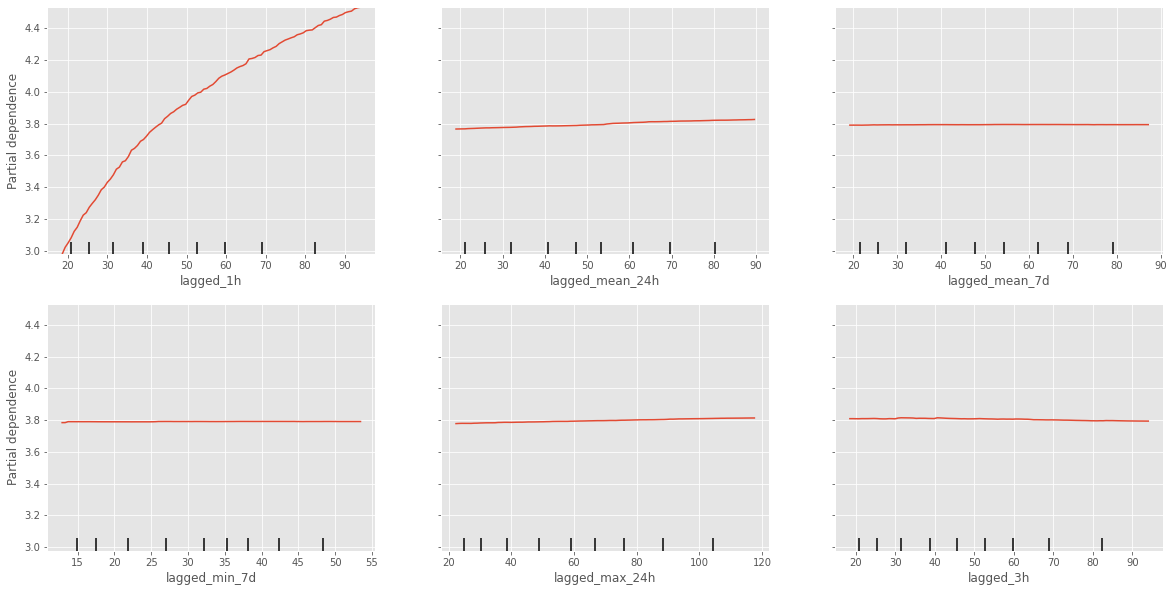

In [77]:
plt.rcParams['figure.figsize']=(20,10)
PartialDependenceDisplay.from_estimator(RF_model,X,
['lagged_1h', 'lagged_mean_24h','lagged_mean_7d',
 'lagged_min_7d','lagged_max_24h','lagged_3h'], 
                                        kind='average', random_state=0)
print("Partial dependence of AIR Pollution on some features with RF model")
plt.show()